In [48]:
%matplotlib inline

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

In [2]:
file_name = 'BPD_Part_1_Victim_Based_Crime_Data.csv'
df = pd.read_csv(file_name)
df = df.set_index(pd.DatetimeIndex(df.CrimeDate))
crime_types = pd.get_dummies(df['Description'])
df2 = pd.concat([df, crime_types], axis=1)
df2.drop(['Description'], axis=1, inplace=True)
df2 = df2[df2.index.year > 2013]

In [3]:
balt_crimes = ['AGG. ASSAULT', 'ARSON', 'AUTO THEFT',
               'BURGLARY','COMMON ASSAULT','HOMICIDE',
               'LARCENY','LARCENY FROM AUTO','RAPE',
               'ROBBERY - CARJACKING','ROBBERY - COMMERCIAL',
               'ROBBERY - RESIDENCE','ROBBERY - STREET', 'SHOOTING']

In [4]:
df2['WEEK'] = df2.index.week
df2['YEAR'] = df2.index.year

In [5]:
# def plot_trend_data(ax, name, series):
#     ax.plot(series.index.date, series)
#     ax.set_title(f"Baltimore Crime Trend for {name}")
#     ax.set_ylim((0, 2))

# fig, ax = plt.subplots(figsize=(14, 2))
# plot_trend_data(ax, 'ARSON', df2['ARSON'])

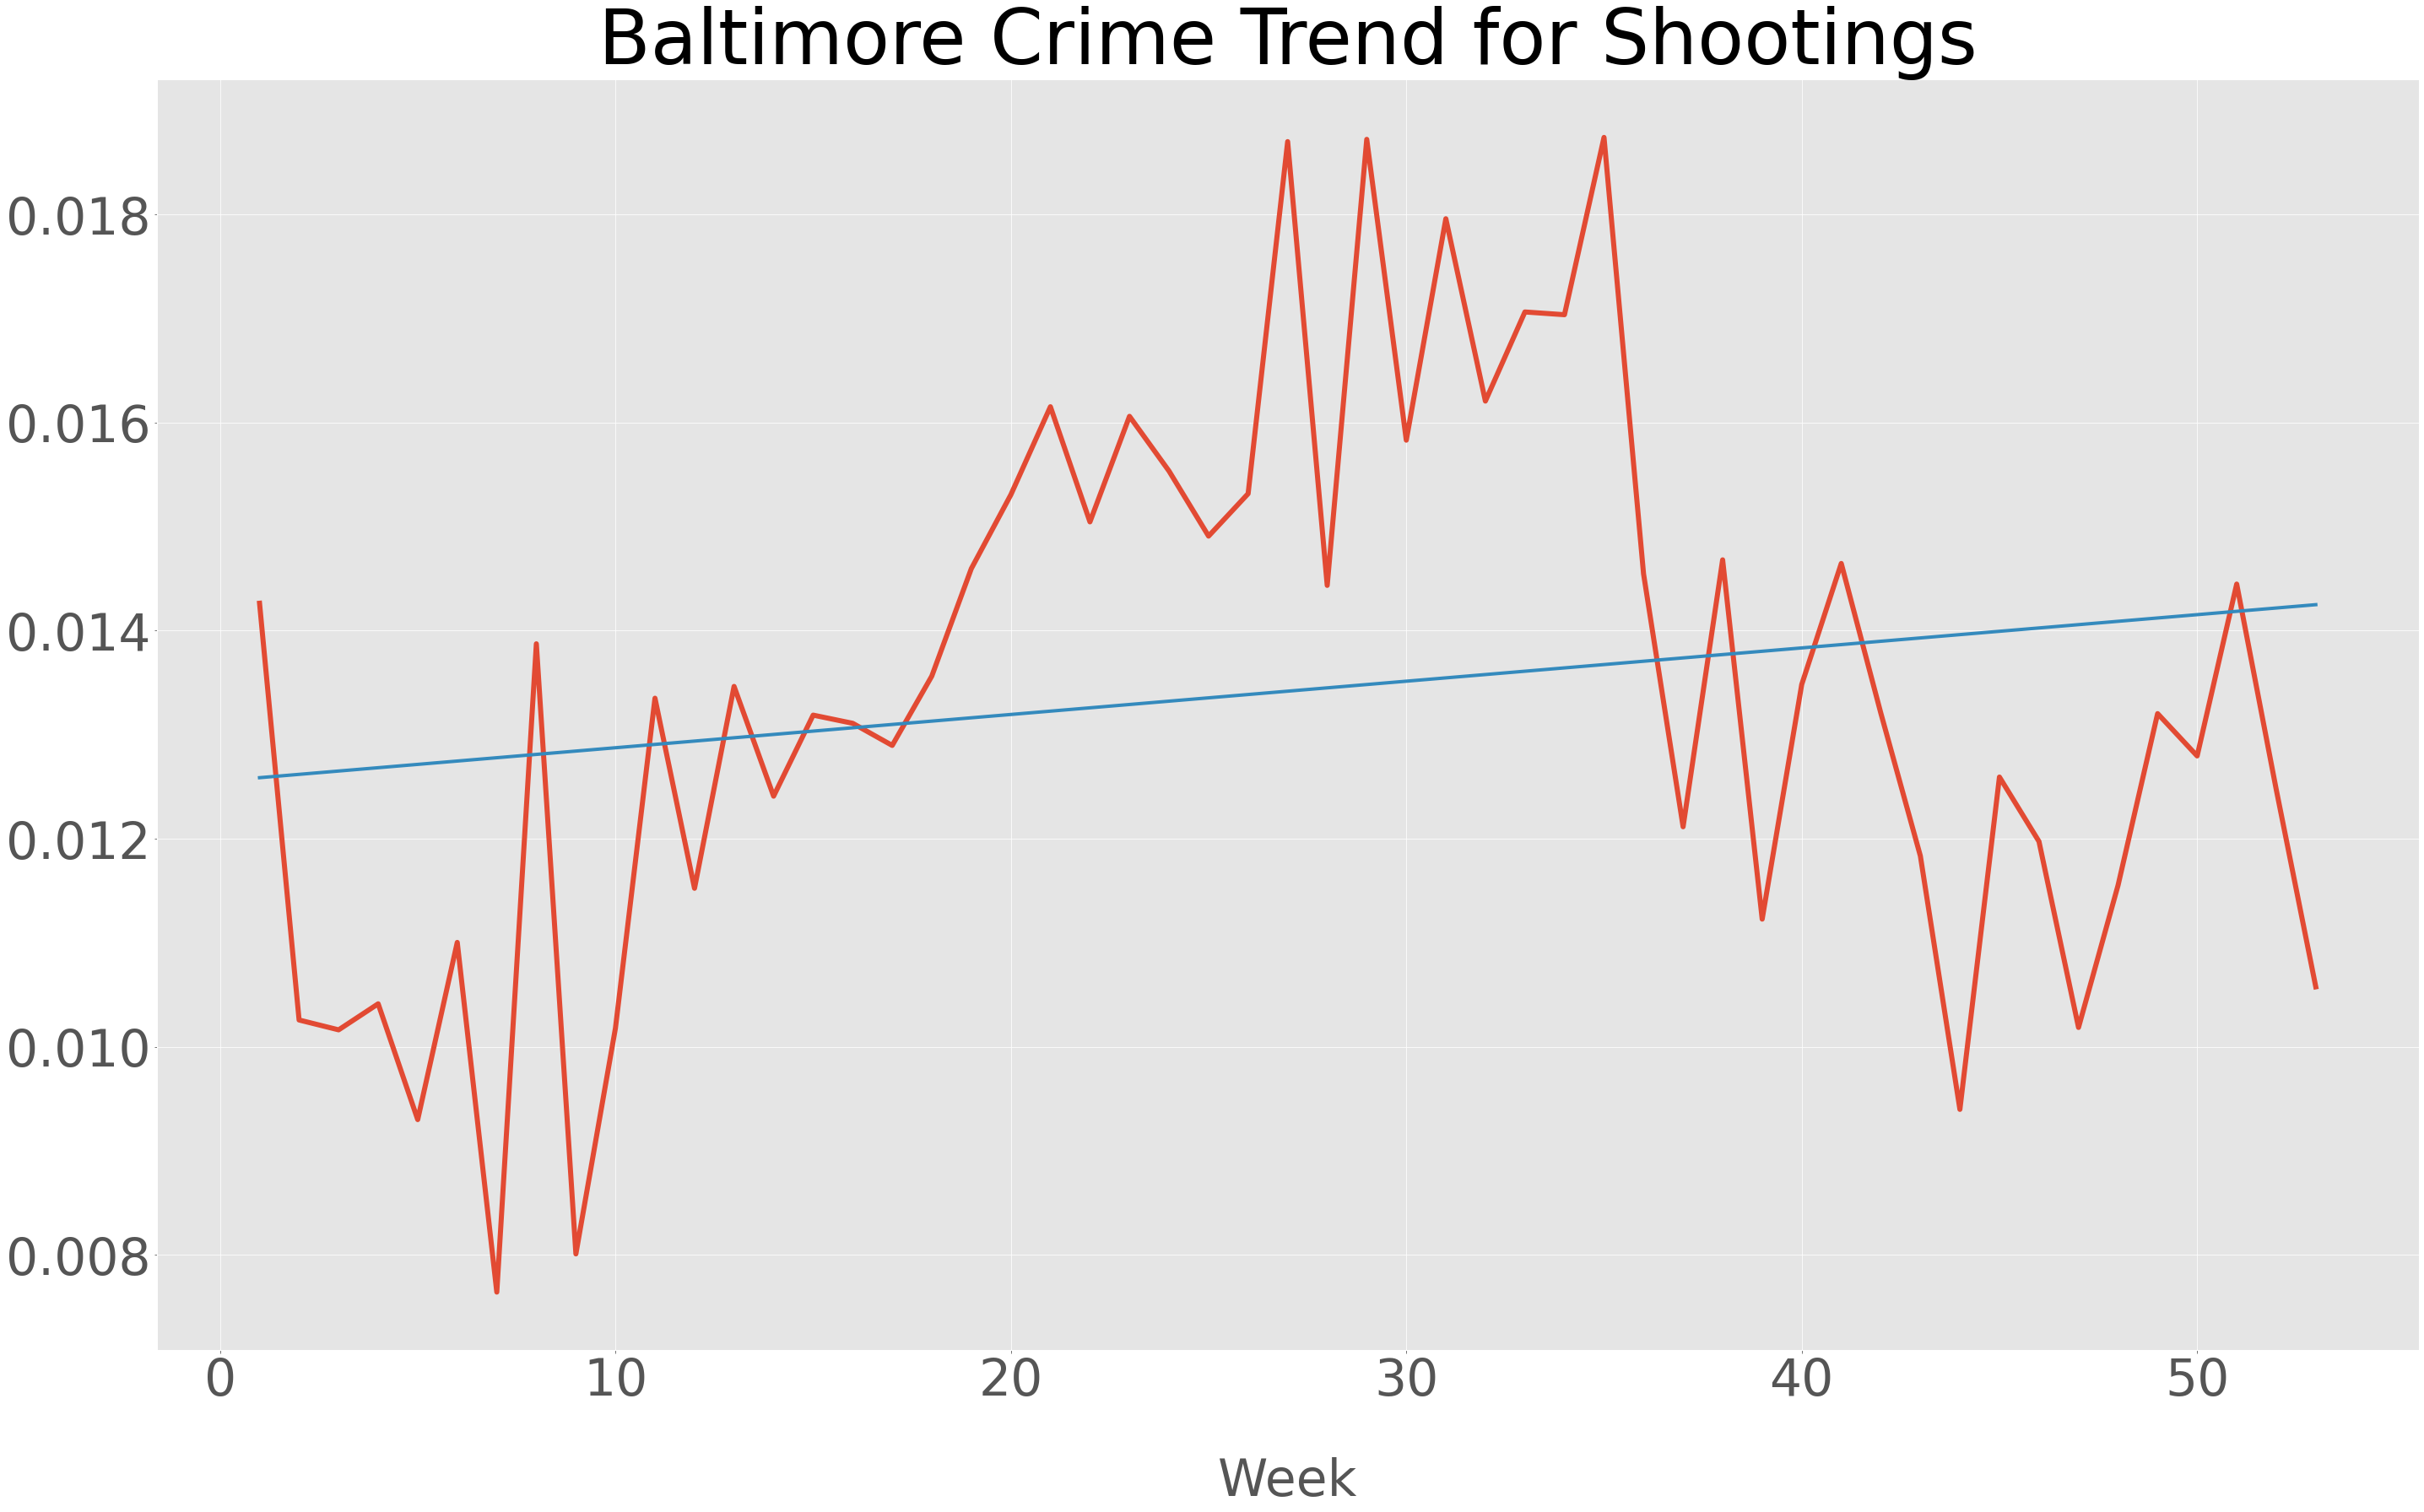

In [21]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series, linewidth=6)
    ax.set_title(f"Baltimore Crime Trend for {name}")
#     ax.set_ylim((0, 2))

def make_design_matrix(arr):
    """Construct a design matrix from a numpy array, converting to a 2-d array
    and including an intercept term."""
    return sm.add_constant(arr.reshape(-1, 1), prepend=False)

def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

def plot_linear_trend(ax, name, series):
    linear_trend = fit_linear_trend(series)
    plot_trend_data(ax, name, series)
#     df2['RAPE'].groupby(df2['WEEK']).mean()
    ax.plot(series.index, linear_trend)


# ax.set_facecolor('w')
fig, ax = plt.subplots(1, figsize=(40, 25))
# plt.rc('font', size=SMALL)
plt.rc('axes', titlesize=90)     
# plt.rc('axes', labelsize=60)   
plt.rc('xtick', labelsize=60)
plt.rc('ytick', labelsize=60)    
# plt.rc('legend', fontsize=SMALL)
plt.rc('lines', linewidth=4)
ax.set_xlabel('Week', labelpad=60, horizontalalignment='center')
plot_linear_trend(ax, 'Shootings', df2['SHOOTING'].groupby(df2['WEEK']).mean())
plt.tight_layout()

## Detrended Shooting Series Data

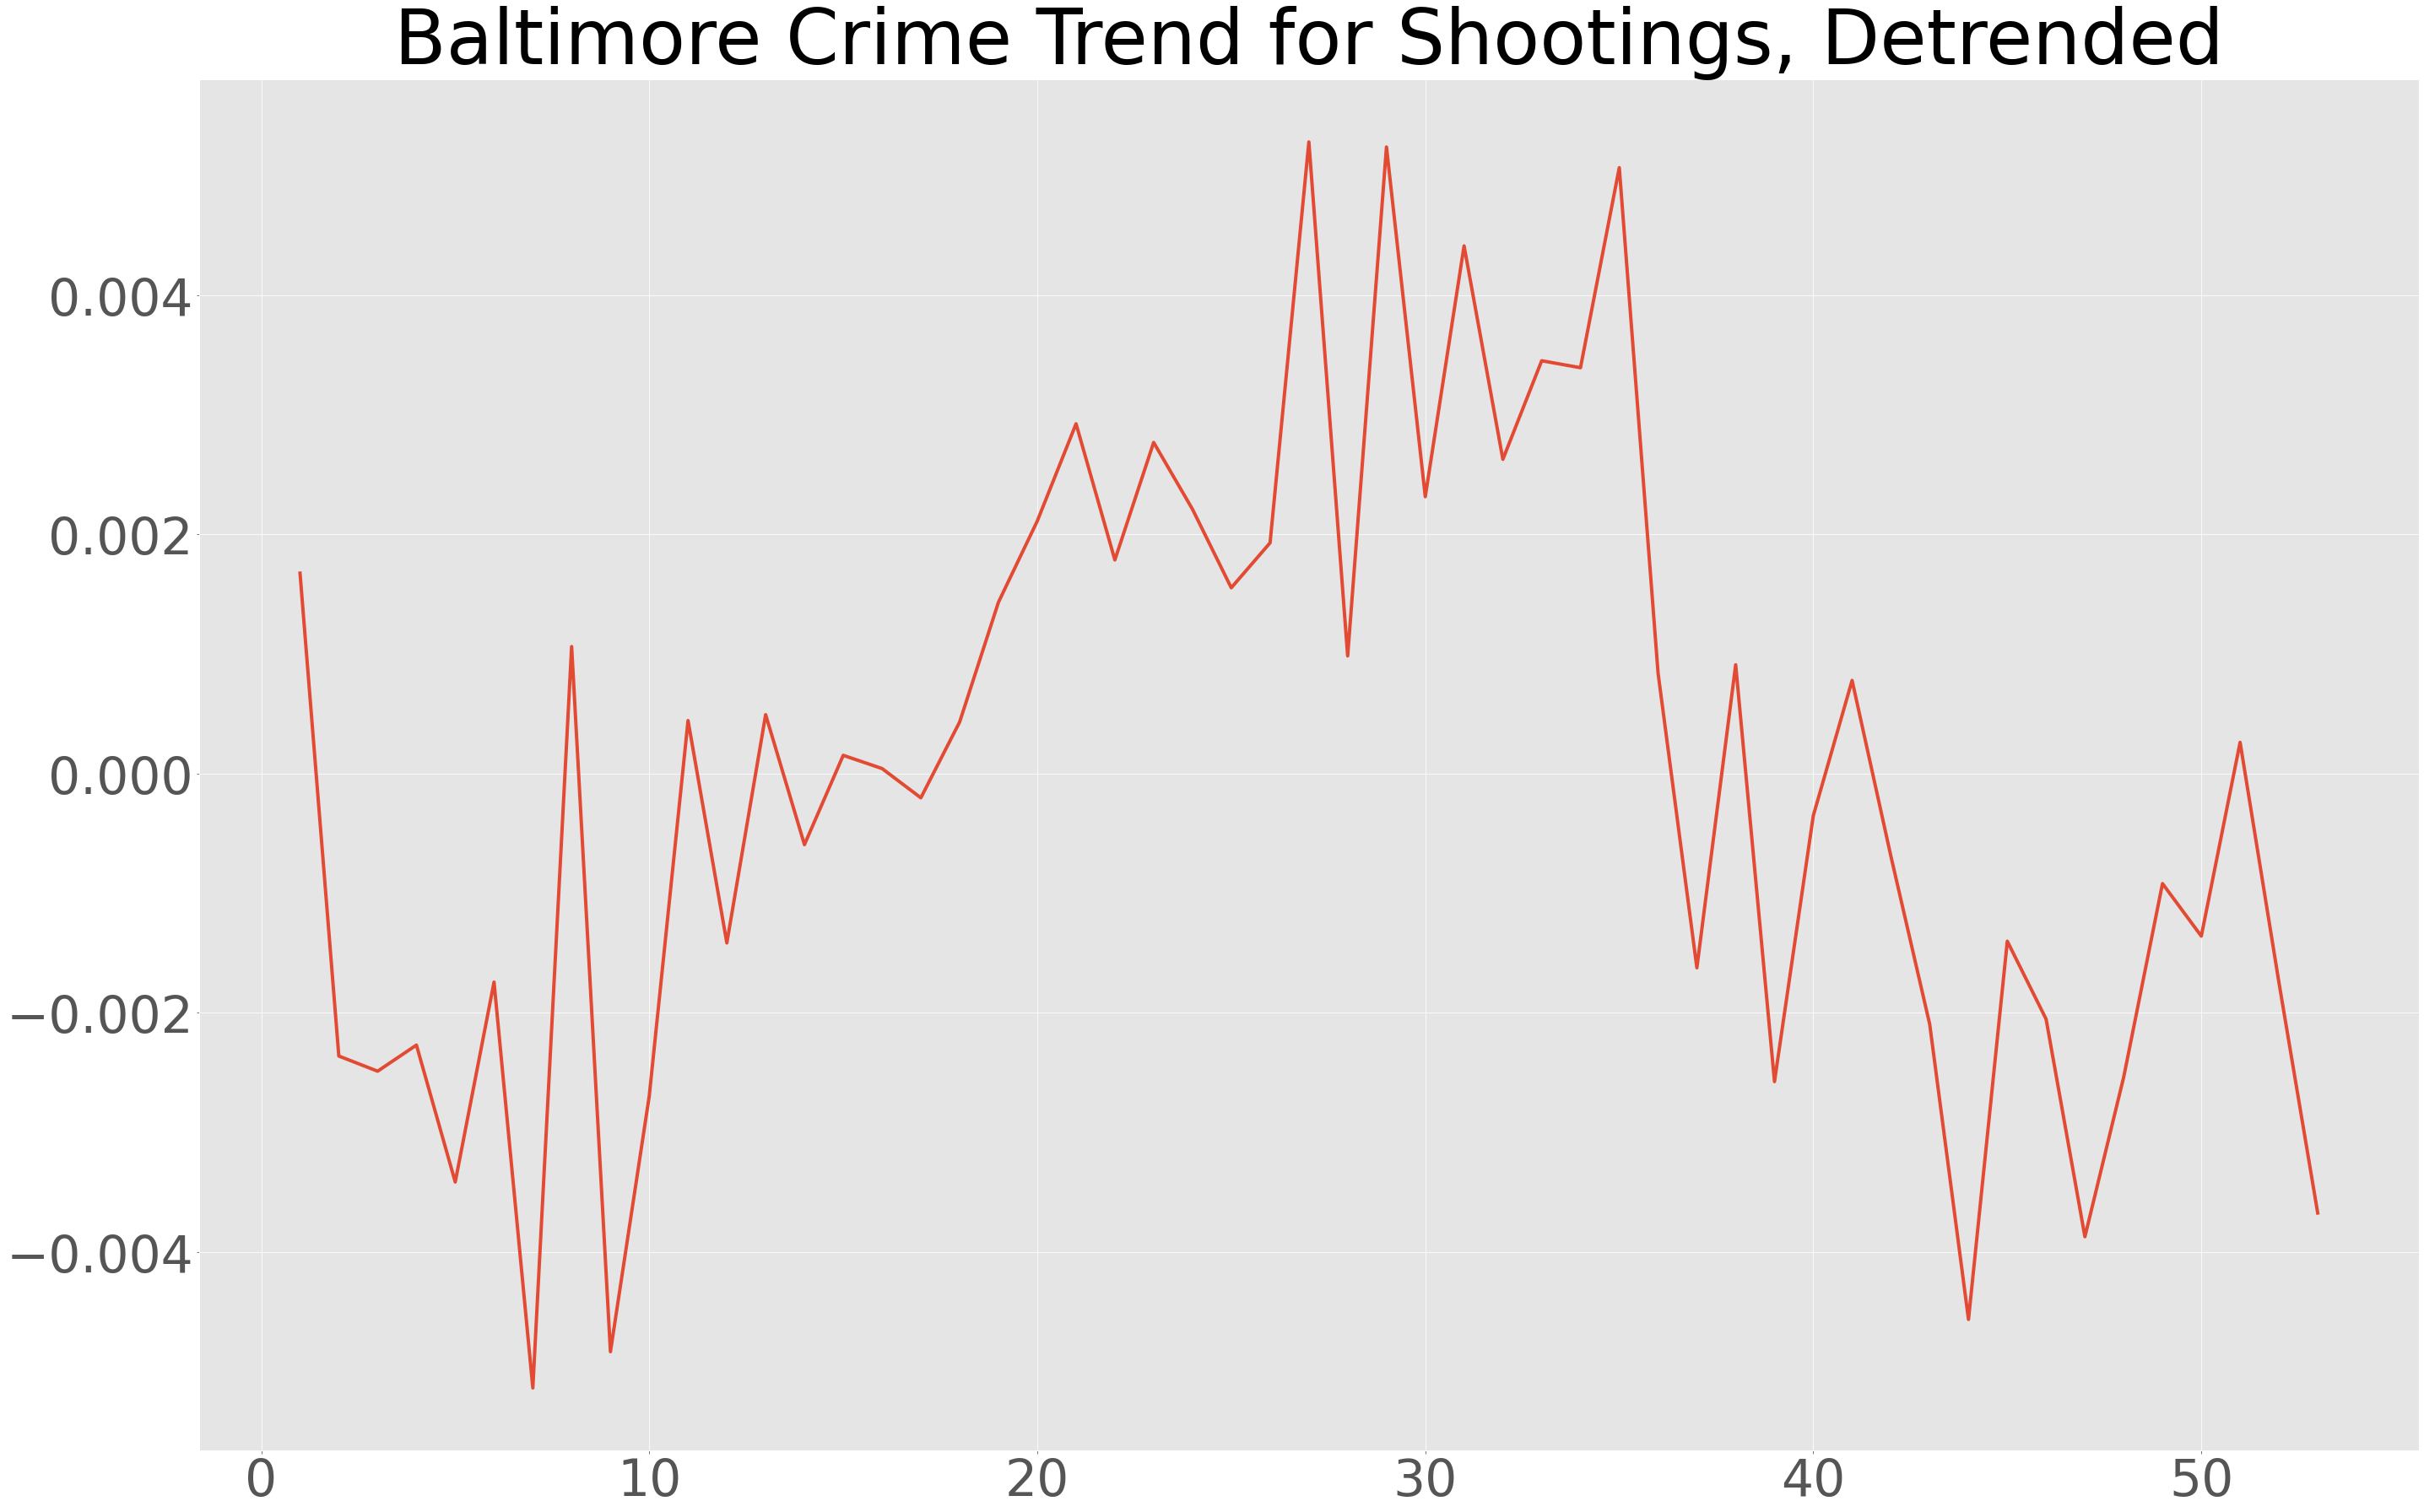

In [22]:
python_series = df2['SHOOTING'].groupby(df2['WEEK']).mean()
python_linear_trend = fit_linear_trend(python_series)
python_series_detrended = python_series - python_linear_trend

fig, ax = plt.subplots(1, figsize=(40, 25))
ax.plot(python_series_detrended.index, python_series_detrended)
ax.set_title(f"Baltimore Crime Trend for Shootings, Detrended")
plt.tight_layout()

Detrending a series is often times a first step in analysing a time series.

Many times time series show a more sophisticated trend than a simple linear increase or decrease, in these cases a more sophisticated detrending procedure is needed.

**BUT**
With my data it would silly to do so. Why? because this isnt strictly linear. the trend is not specific as of yet.

## Moving Average Trend

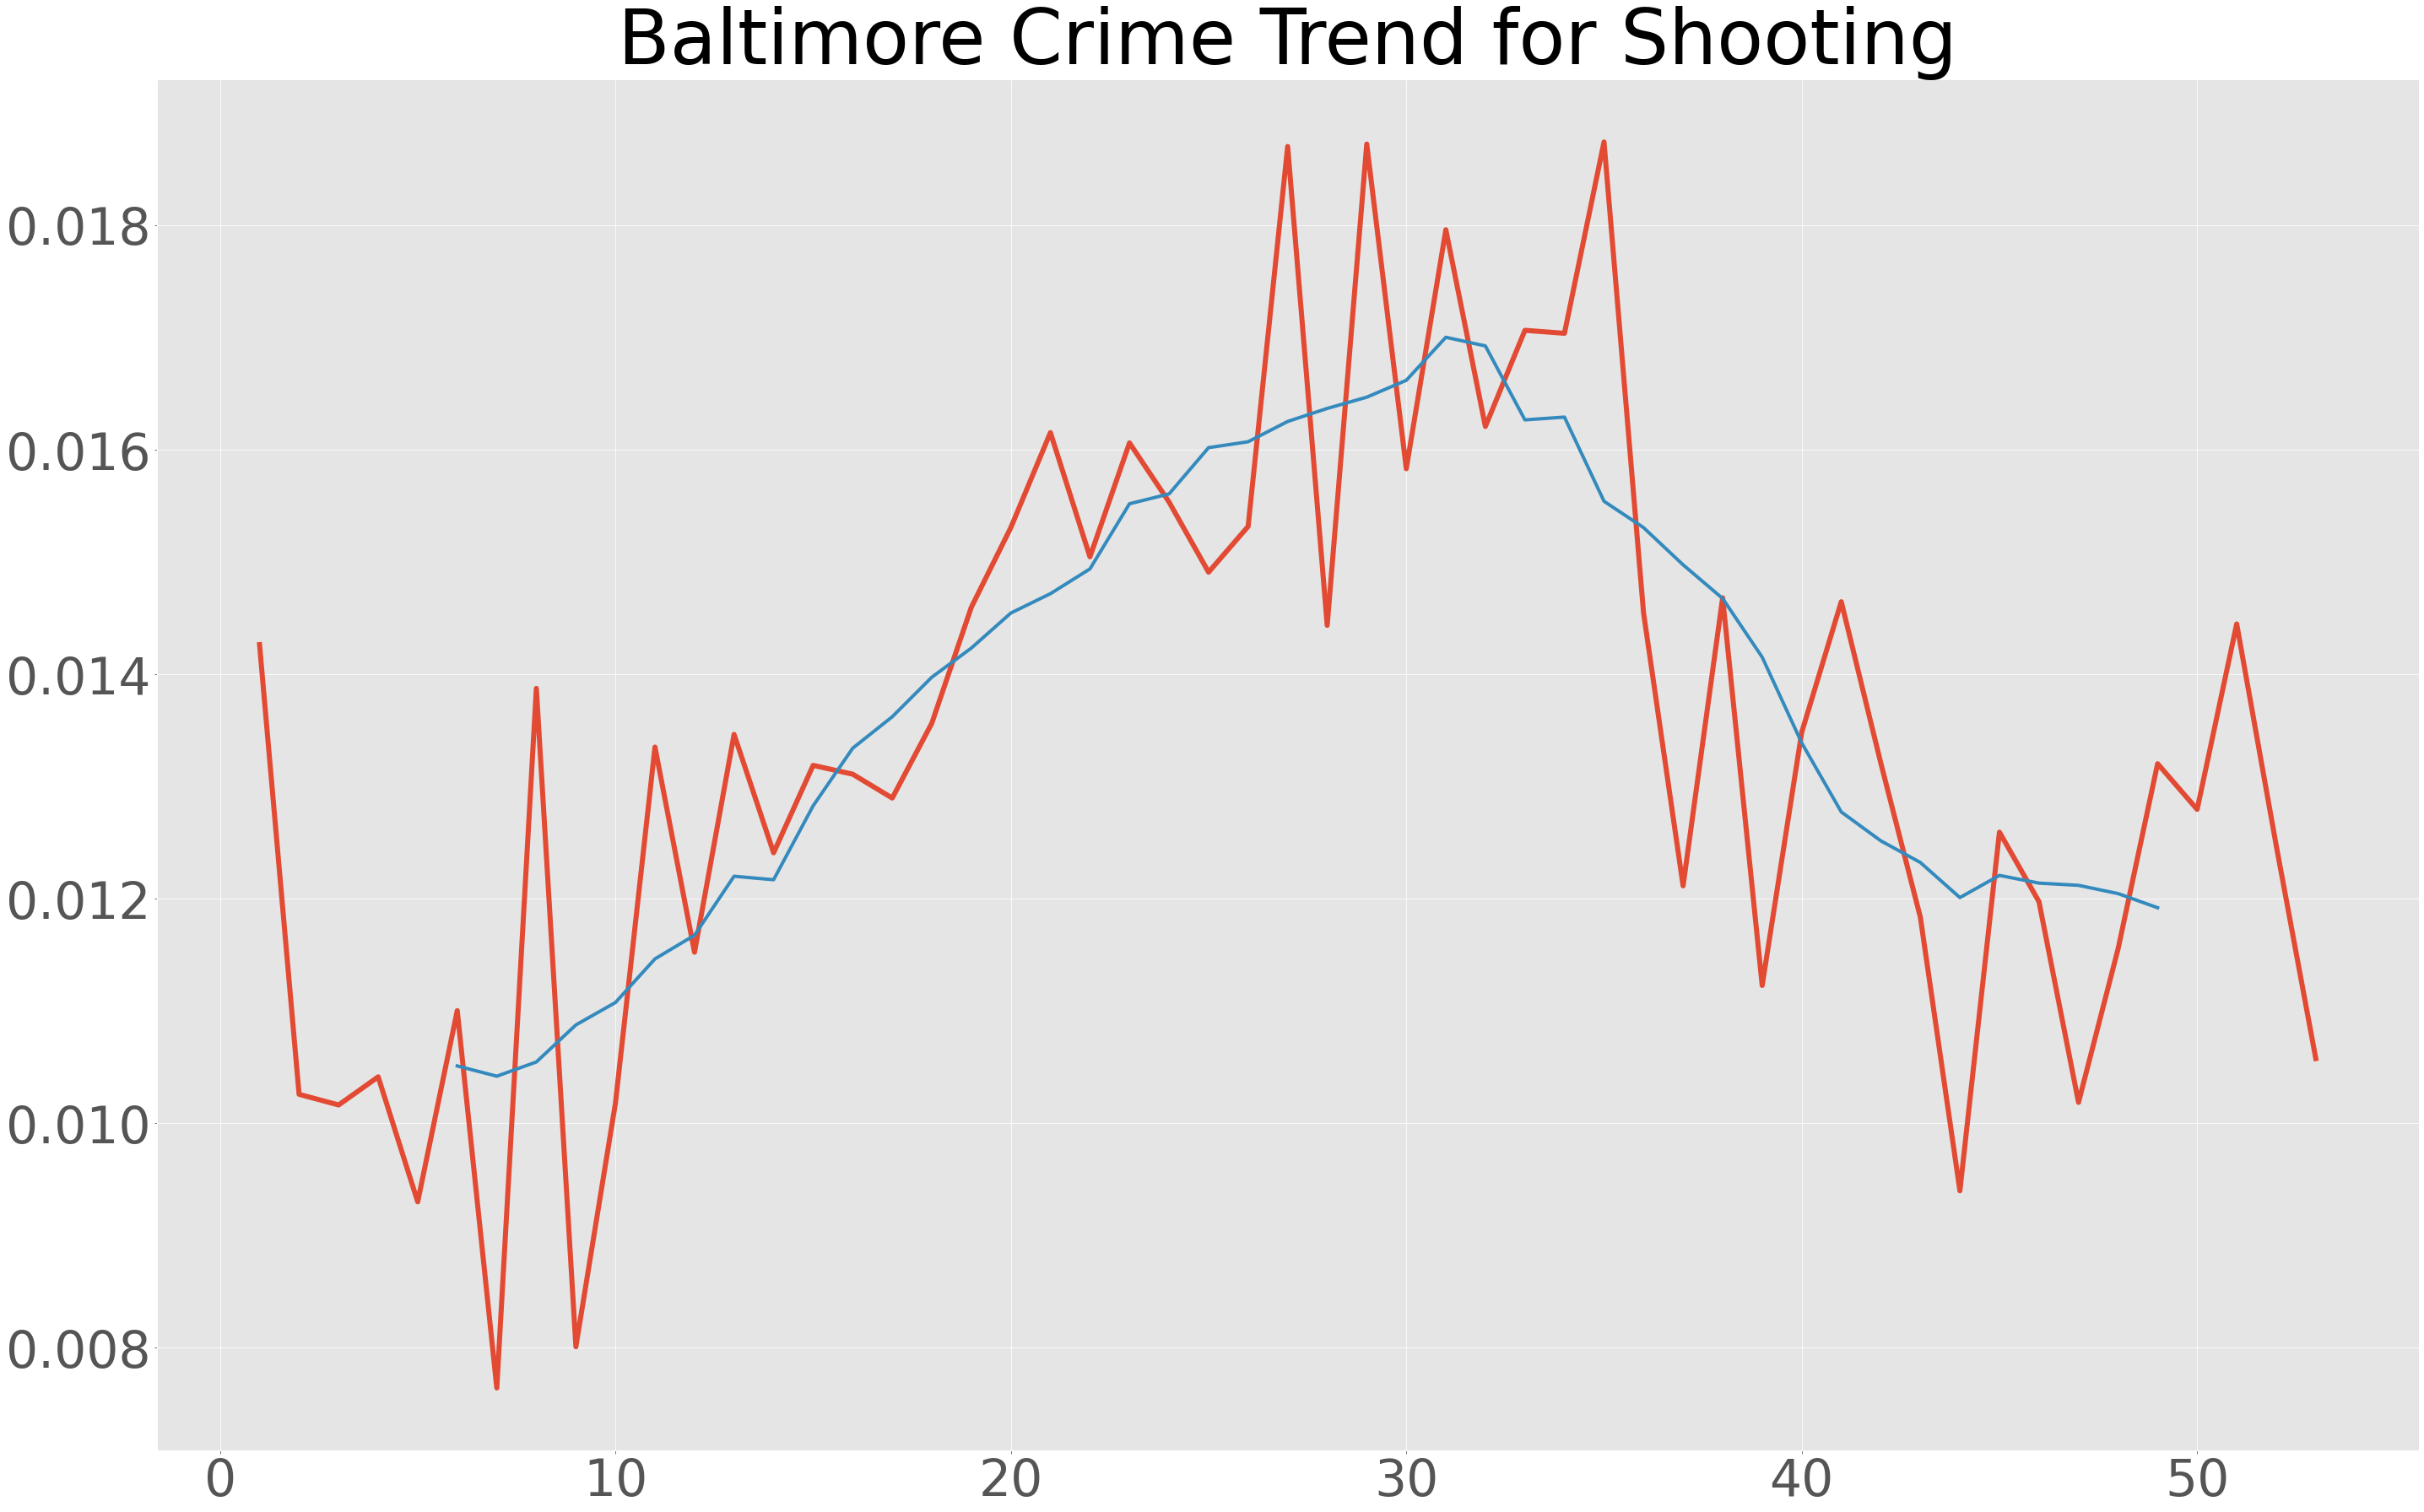

In [23]:
def fit_moving_average_trend(series, window=10):
#    return pd.rolling_mean(series, window, center=True)
    return series.rolling(window, center=True).mean()

def plot_moving_average_trend(ax, name, series, window=10):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, moving_average_trend)

fig, axs = plt.subplots(1, figsize=(40, 25))
plot_moving_average_trend(axs, 'Shooting', df2['SHOOTING'].groupby(df2['WEEK']).mean())
plt.tight_layout()

Varying the window param changes the quality of the moving average fit.

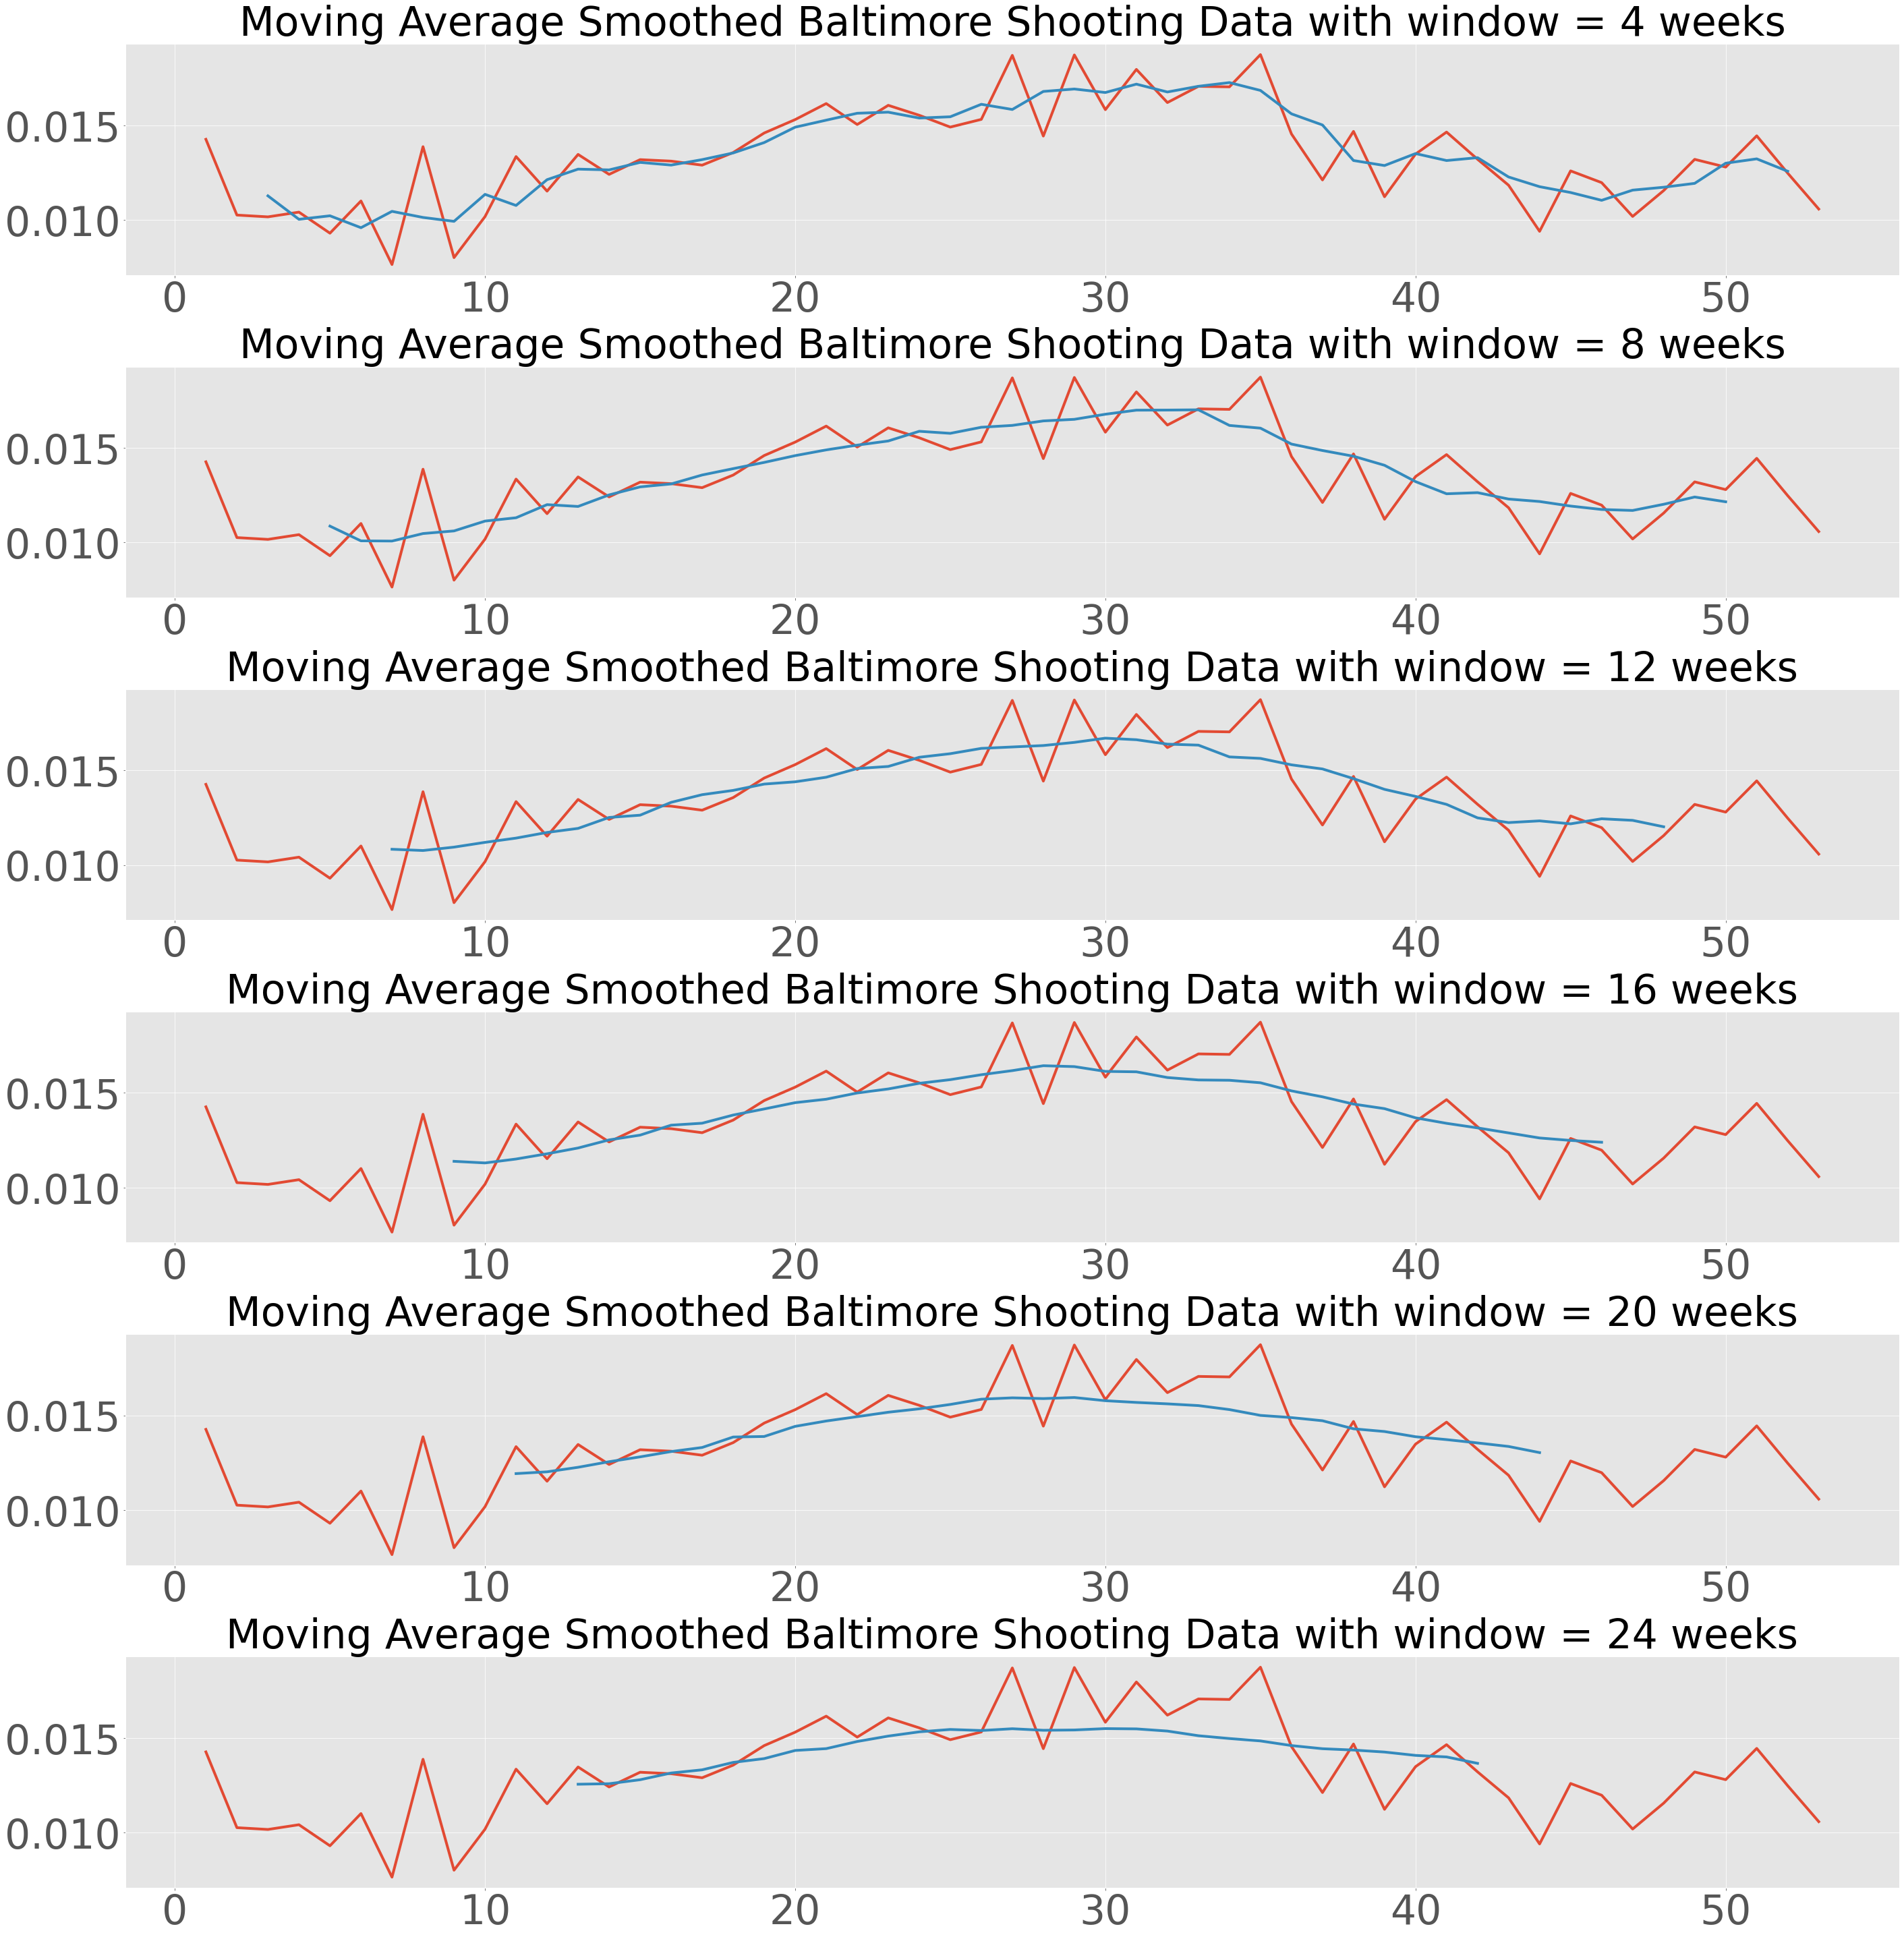

In [24]:
fig, axs = plt.subplots(6, figsize=(40, 40))

shooting_series = df2['SHOOTING'].groupby(df2['WEEK']).mean()
for i, window in enumerate([4, 8, 12, 16, 20, 24]):
    axs[i].plot(shooting_series.index, shooting_series)
    axs[i].plot(shooting_series.index, fit_moving_average_trend(shooting_series, window=window))
    axs[i].set_title("Moving Average Smoothed Baltimore Shooting Data with window = {} weeks".format(window), fontsize=60)
    
plt.tight_layout()

## Seasonality

In [25]:
def create_weekly_dummies(series):
    series.index = series.index.get_level_values('WEEK')
    week = series.index
    
    # Only take 11 of the 12 dummies to avoid strict colinearity.
    return pd.get_dummies(week).iloc[:, :51]

In [26]:
def fit_seasonal_trend(series):
    dummies = create_weekly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
#     print(dummies.shape, series.values.shape, X)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

In [27]:
def plot_seasonal_trend(ax, name, series):
    seasons_average_trend = fit_seasonal_trend(series)
    ax.plot(series.values)
    ax.plot(seasons_average_trend, '-')
    print(seasons_average_trend.shape, series.shape)

Linear regression model fit to the shooting trend with weekly dummy variables.

(347,) (347,)


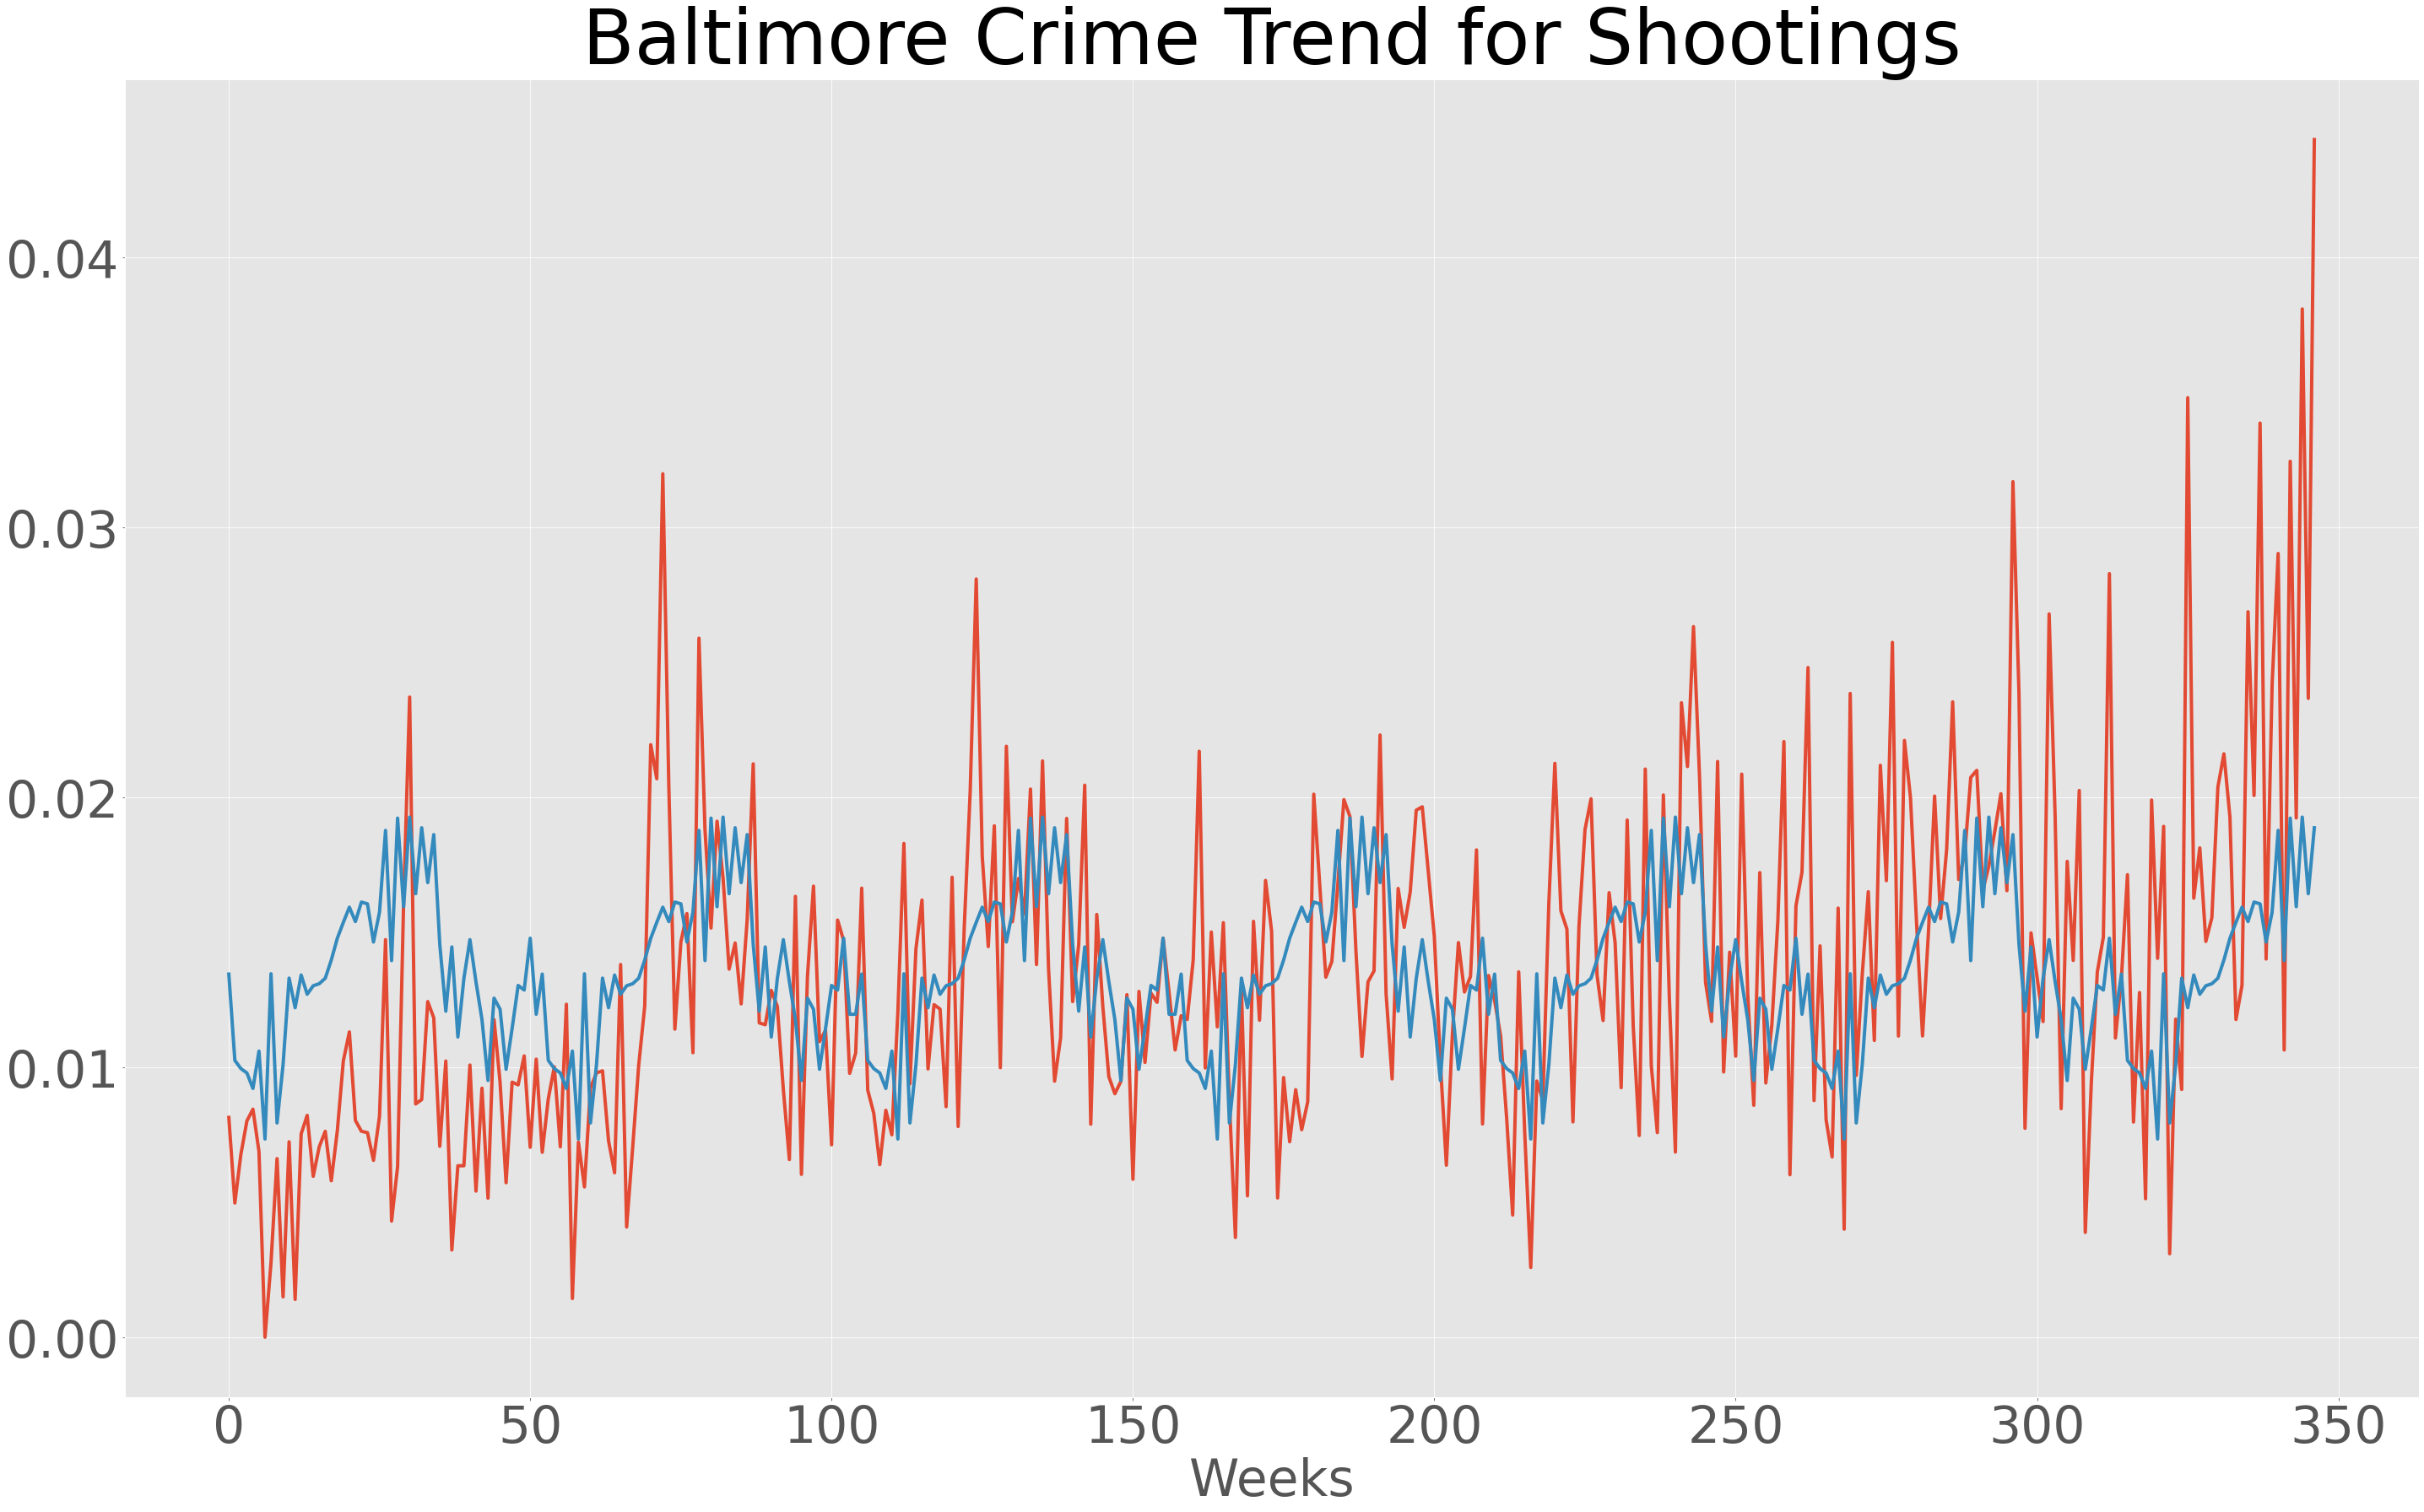

In [33]:
fig, ax = plt.subplots(figsize=(40, 25))
ax.set_title('Baltimore Crime Trend for Shootings')
ax.set_xlabel('Weeks')

plot_seasonal_trend(ax, 'Shooting', df2.groupby(['YEAR', 'WEEK']).mean()['SHOOTING'])
plt.tight_layout()

In [198]:
crime_series = df2.groupby(['YEAR', 'WEEK']).count()
crime_series.SHOOTING.tail()

YEAR  WEEK
2020  29      709
      30      676
      31      604
      32      634
      33      496
Name: SHOOTING, dtype: int64

In [197]:
df2.head()

CrimeDate CrimeTime CrimeCode                 Location  \
CrimeDate                                                             
2020-08-15  08/15/2020  22:45:00        6E            0 S CURLEY ST   
2020-08-15  08/15/2020  05:45:00      3AJF         5700 EASTERN AVE   
2020-08-15  08/15/2020  15:00:00        5A  3700 MOUNT PLEASANT AVE   
2020-08-15  08/15/2020  11:30:00        5A         1700 AISQUITH ST   
2020-08-15  08/15/2020  16:30:00        3B          1800 N CAREY ST   

           Inside/Outside   Weapon Post   District         Neighborhood  \
CrimeDate                                                                 
2020-08-15              O      NaN  222  SOUTHEAST    BALTIMORE-LINWOOD   
2020-08-15              O  FIREARM  232  SOUTHEAST              BAYVIEW   
2020-08-15              I      NaN  223  SOUTHEAST  BALTIMORE HIGHLANDS   
2020-08-15              I      NaN  314    EASTERN               OLIVER   
2020-08-15              O      NaN  734    WESTERN  SANDTOWN-WINCHESTER   

            Longitude  ...  LARCENY  LARCENY FROM AUTO RAPE  \
CrimeDate              ...                                    
2020-08-15 -76.575446  ...        1                  0    0   
2020-08-15 -76.547655  ...        0                  0    0   
2020-08-15 -76.566410  ...        0                  0    0   
2020-08-15 -76.602439  ...        0                  0    0   
2020-08-15 -76.643720  ...        0                  0    0   

           ROBBERY - CARJACKING  ROBBERY - COMMERCIAL  ROBBERY - RESIDENCE  \
CrimeDate                                                                    
2020-08-15                    0                     0                    0   
2020-08-15                    1                     0                    0   
2020-08-15                    0                     0                    0   
2020-08-15                    0                     0                    0   
2020-08-15                    0                     0                    0   

            ROBBERY - STREET  SHOOTING  WEEK  YEAR  
CrimeDate                                           
2020-08-15                 0         0    33  2020  
2020-08-15                 0         0    33  2020  
2020-08-15                 0         0    33  2020  
2020-08-15                 0         0    33  2020  
2020-08-15                 1         0    33  2020  

[5 rows x 31 columns]

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
           dtype='int64', name='WEEK', length=347)        CrimeDate   CrimeTime   CrimeCode    Location  Inside/Outside  \
WEEK                                                                   
1      68.714286   68.714286   68.714286   68.000000      200.428571   
2     -44.571429  -44.571429  -44.571429  -43.000000      125.571429   
3      42.571429   42.571429   42.571429   43.857143      185.285714   
4     -60.428571  -60.285714  -60.428571  -60.285714       22.714286   
5      14.857143   14.857143   14.857143   16.428571       76.857143   
...          ...         ...         ...         ...             ...   
29   -260.142857 -260.000000 -260.142857 -260.000000     -264.285714   
30   -307.714286 -307.714286 -307.714286 -305.714286     -277.000000   
31   -334.714286 -334.428571 -334.714286 -328.000000     -263.142857   
32   -335.714286 -336.571429 -335.71

ValueError: x and y must have same first dimension, but have shapes (1,) and (347, 29)

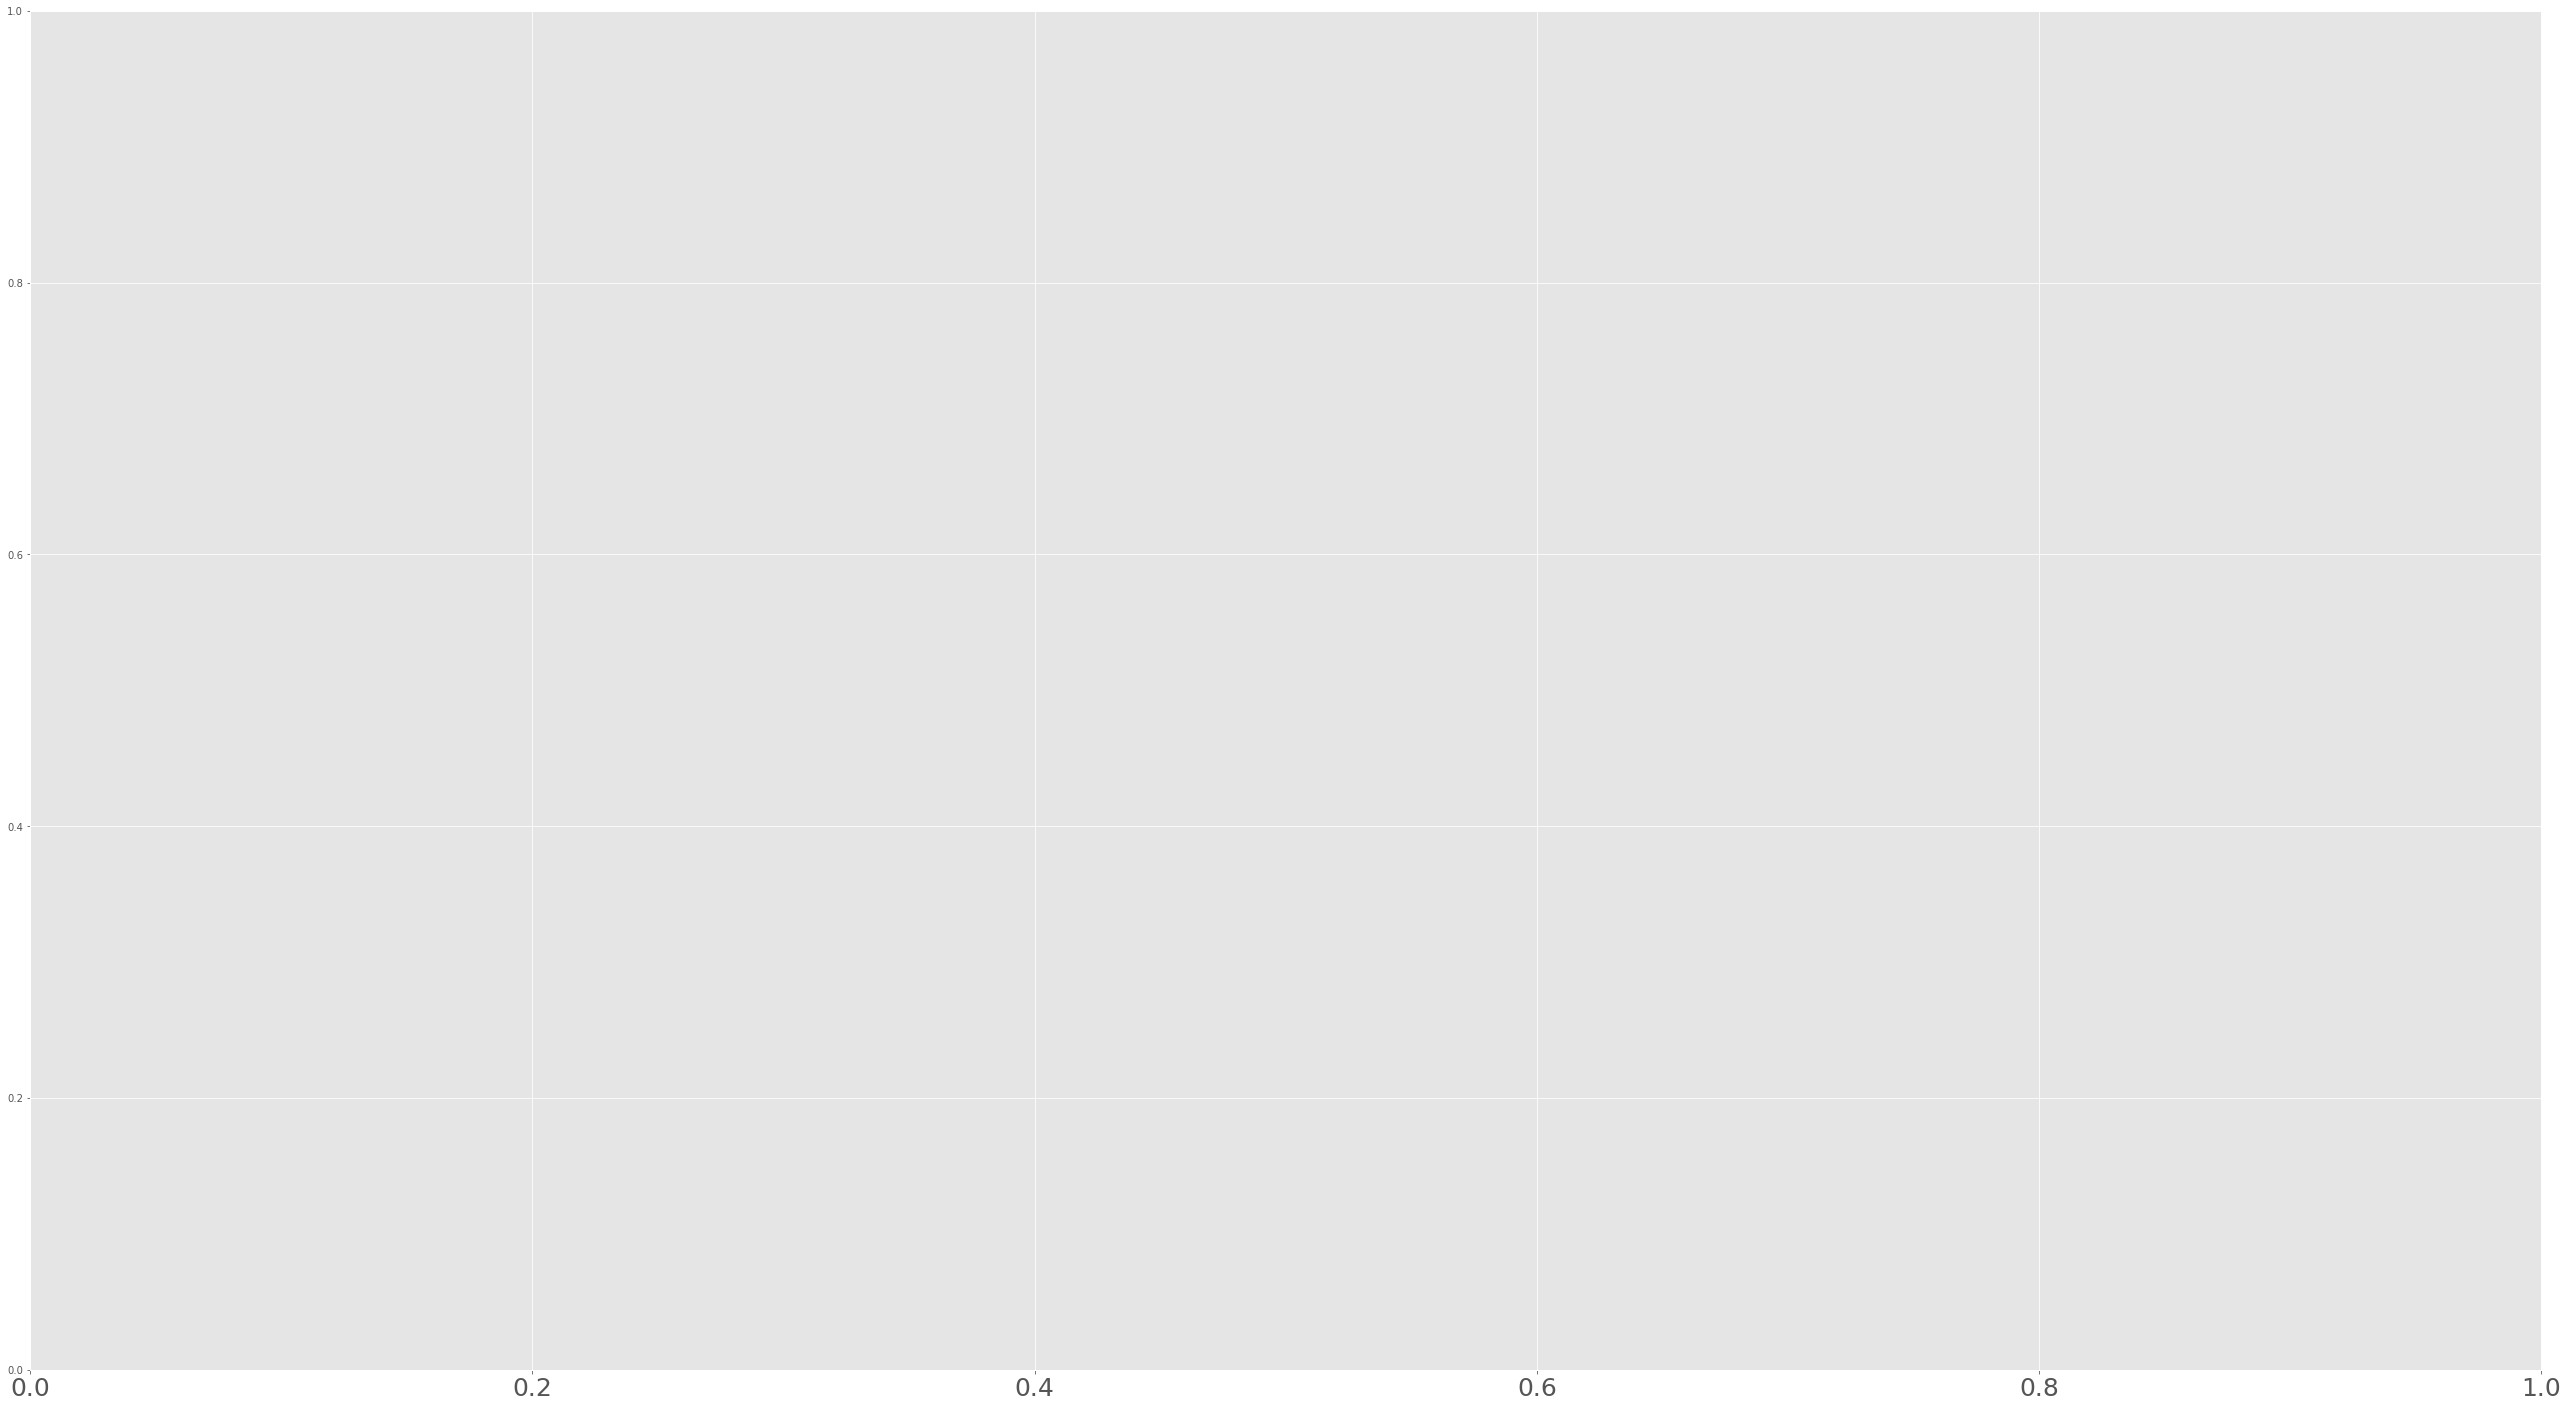

In [199]:
crime_seasonal_trend = fit_seasonal_trend(crime_series)
crime_seasonal_detrended = crime_series - crime_seasonal_trend

print(crime_series.index, crime_seasonal_detrended)

fig, ax = plt.subplots(figsize=(45, 25))
ax.plot(ax, crime_series)
ax.set_title("Baltimore Crime for Shootings, Deseasonalized")

### Trend-Seasonal-Residual Decomp

In [202]:
x = df2.groupby(df2.index)['SHOOTING'].count()

python_decomposition = sm.tsa.seasonal_decompose(x)

In [203]:
def plot_shared_yscales(axs, x, ys, titles):
    ymiddles =  [ (y.max()+y.min())/2 for y in ys ]
    yrange = max( (y.max()-y.min())/2 for y in ys )
    for ax, y, title, ymiddle in zip(axs, ys, titles, ymiddles):
        ax.plot(x, y)
        ax.set_title(title)
        ax.set_ylim((ymiddle-yrange, ymiddle+yrange))

In [204]:
def plot_seasonal_decomposition(axs, series, sd):
    plot_shared_yscales(axs,
                        series.index,
                        [series, sd.trend, sd.seasonal, sd.resid],
                        ["Raw Series", "Trend Component $T_t$", "Seasonal Component $S_t$", "Residual Component $R_t$"])

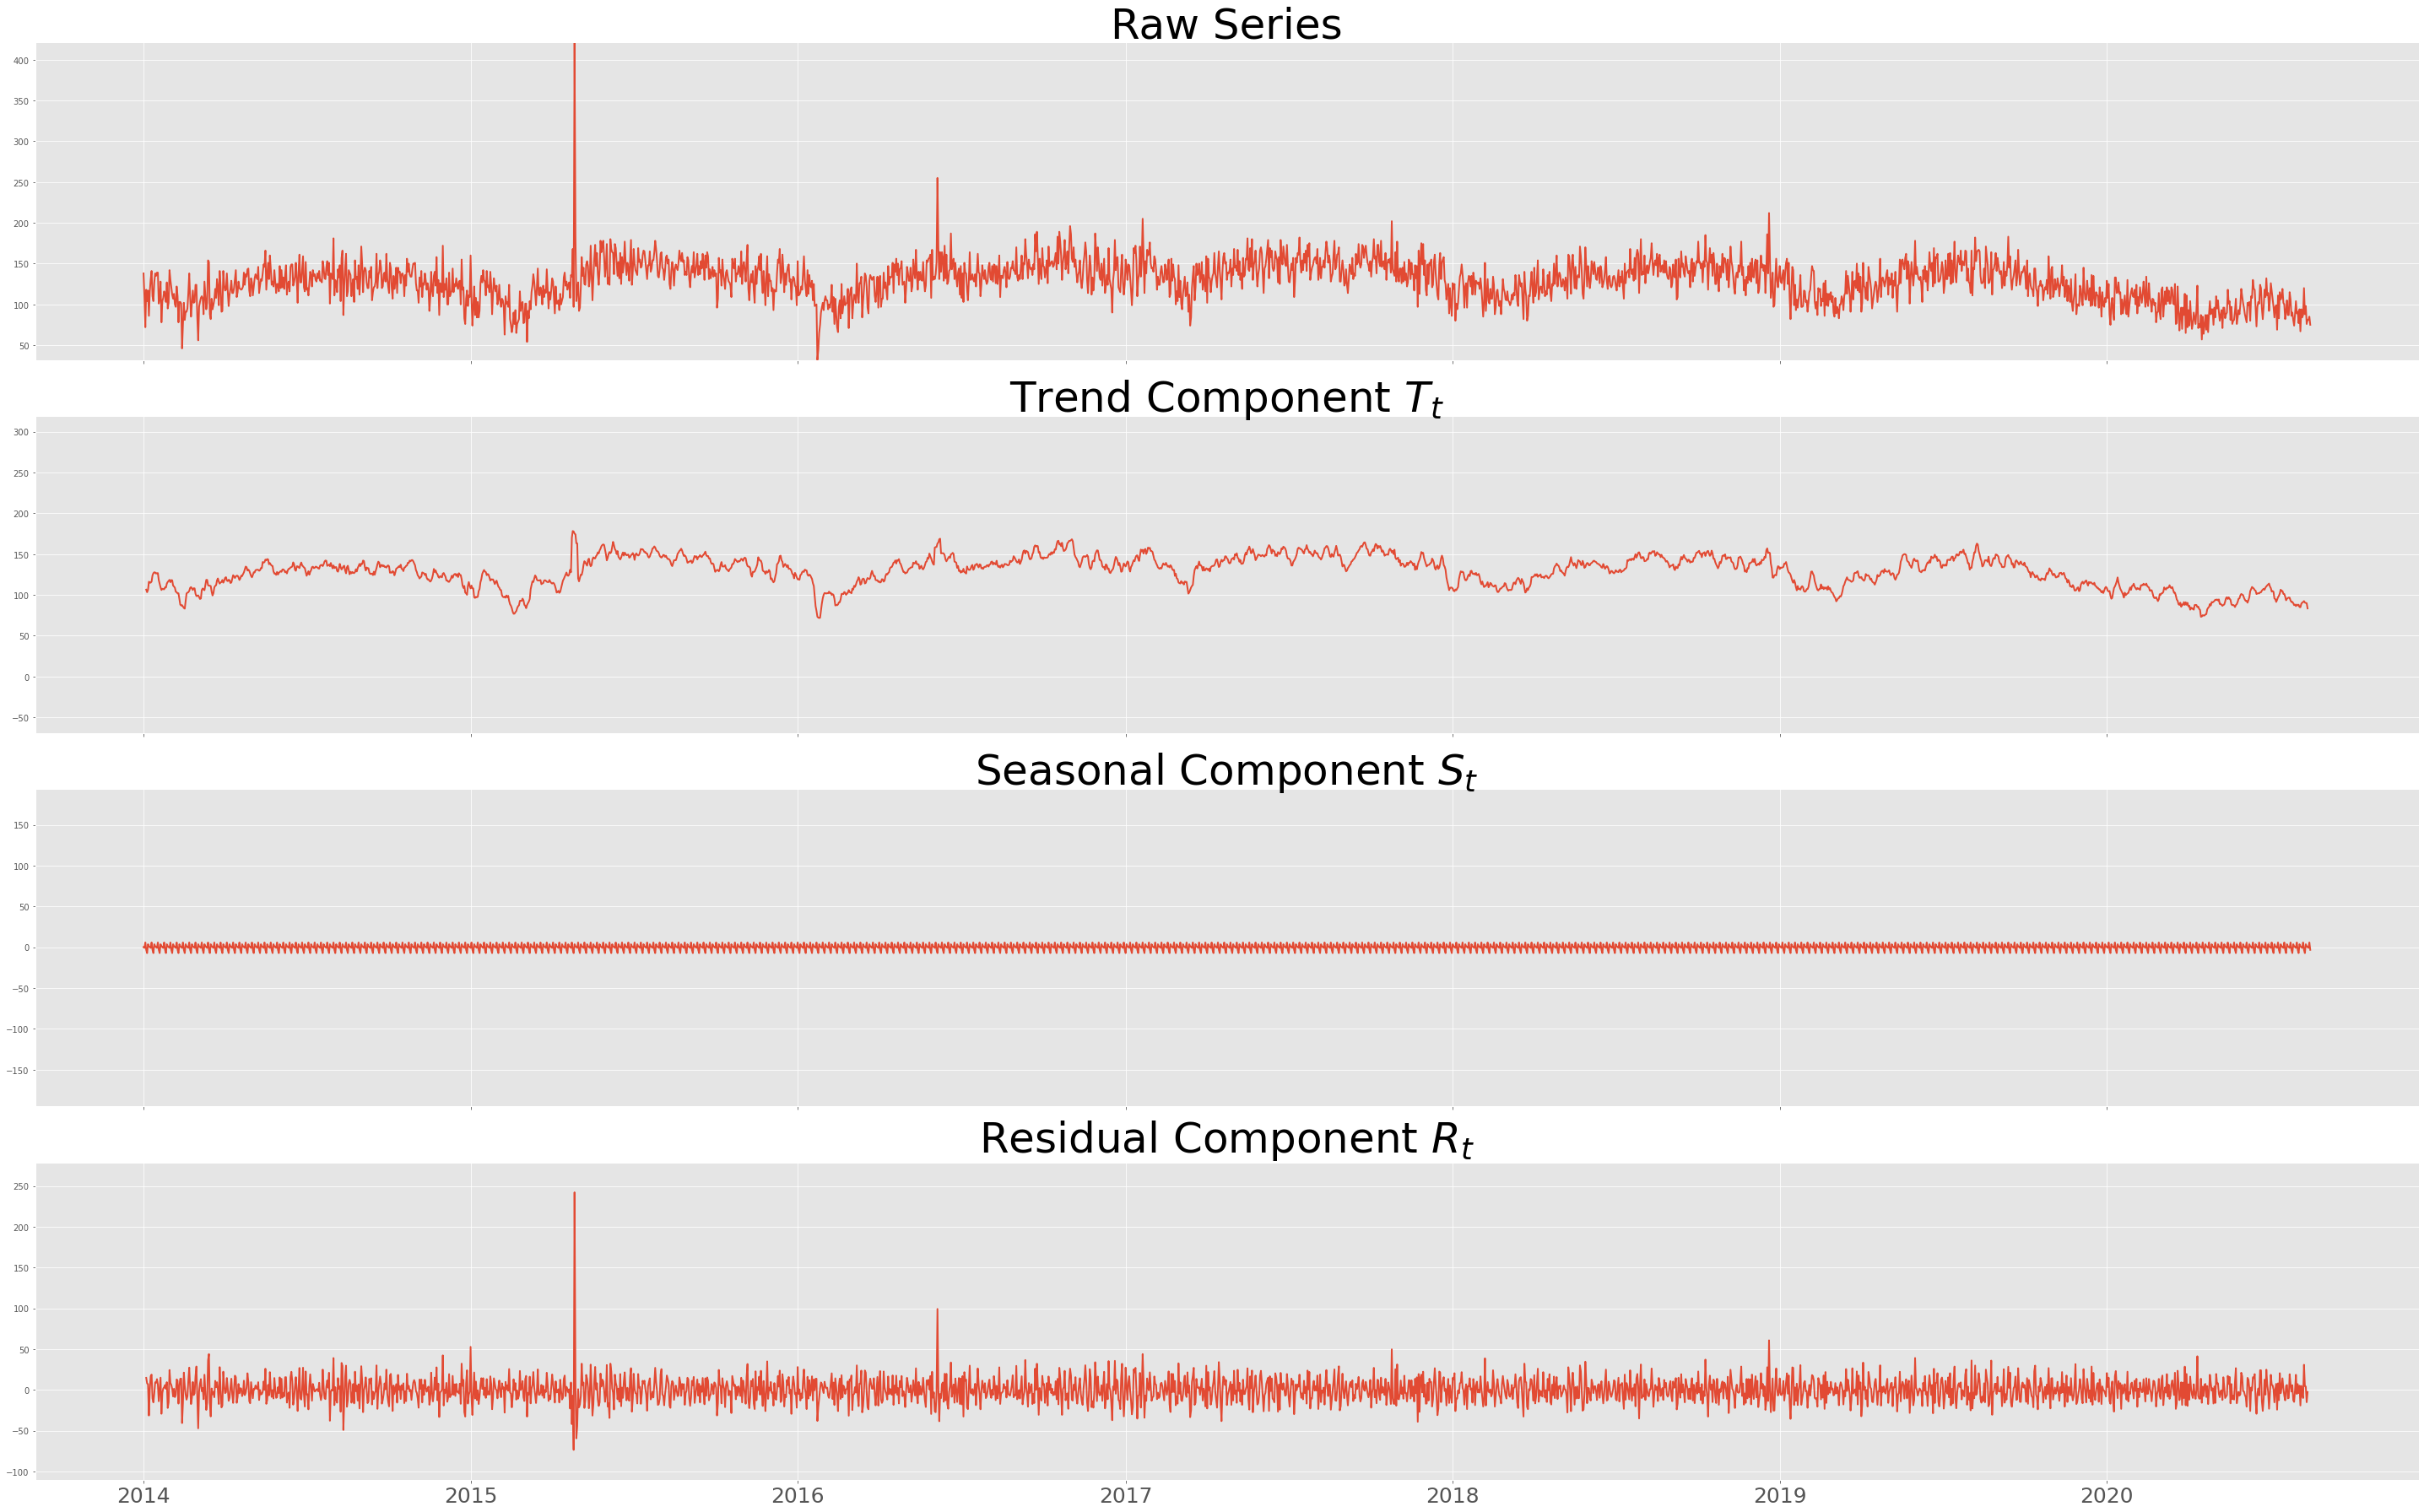

In [205]:
fig, axs = plt.subplots(4, figsize=(40, 25), sharex=True)
plot_seasonal_decomposition(axs, x, python_decomposition)
plt.tight_layout()

In [206]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index.date, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index.date, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

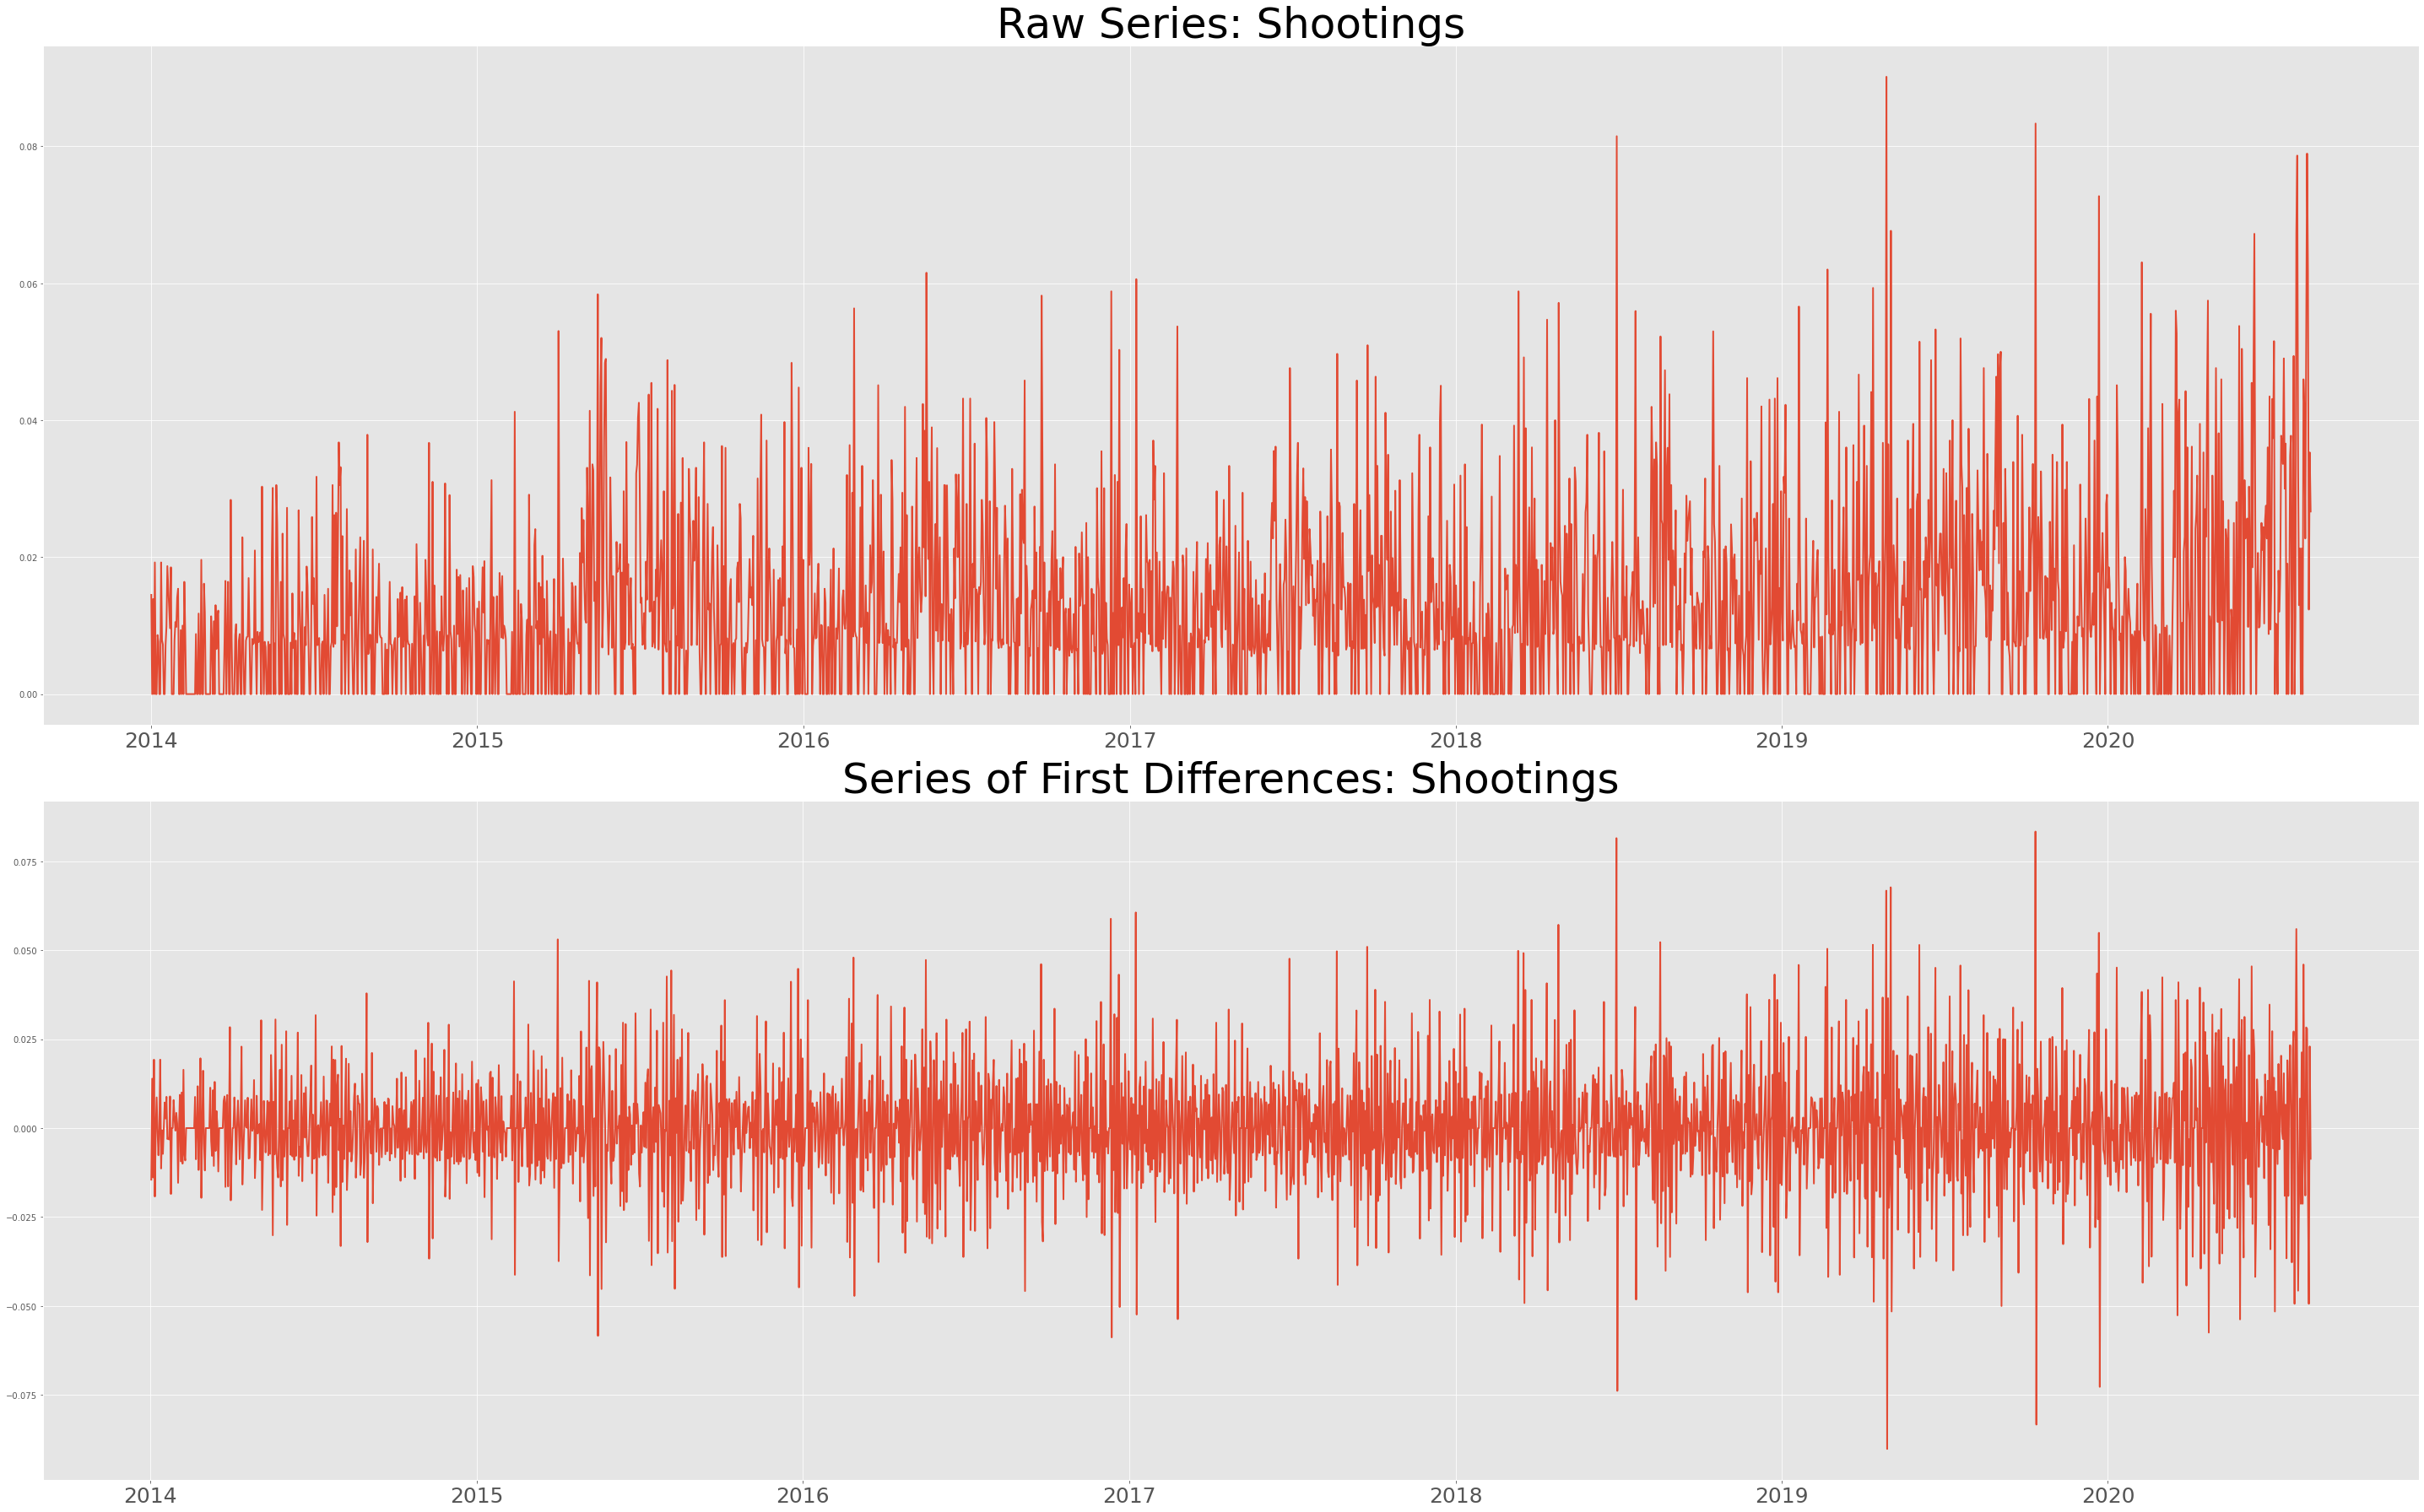

In [207]:
fig, axs = plt.subplots(2, figsize=(40, 25))
plot_series_and_difference(axs, df2.groupby(df2.index).mean()['SHOOTING'], 'Shootings')
fig.tight_layout()

In [59]:
def linear_combination_of_white_noise(size, coef):
    coef = np.asarray(coef)
    n_coef = len(coef)
    noise_size = size + len(coef)
    noise = np.random.normal(size=noise_size)
    # np.convolve reverses the second array :/
    # We need to subset the result to remove edge effects.
    lc = np.convolve(noise, coef[::-1])[(n_coef-1):(size+n_coef-1)]
    return pd.Series(lc)

In [63]:
series = df2.groupby(df2.index).mean()['SHOOTING']

def series_and_lagged(series, lag=1):
    truncated = np.copy(series)[lag:]
    lagged = np.copy(series)[:(len(truncated))]
    return truncated, lagged

def compute_autocorrelation(series, lag=1):
    series, lagged = series_and_lagged(series, lag=lag)
    return np.corrcoef(series, lagged)[0, 1]

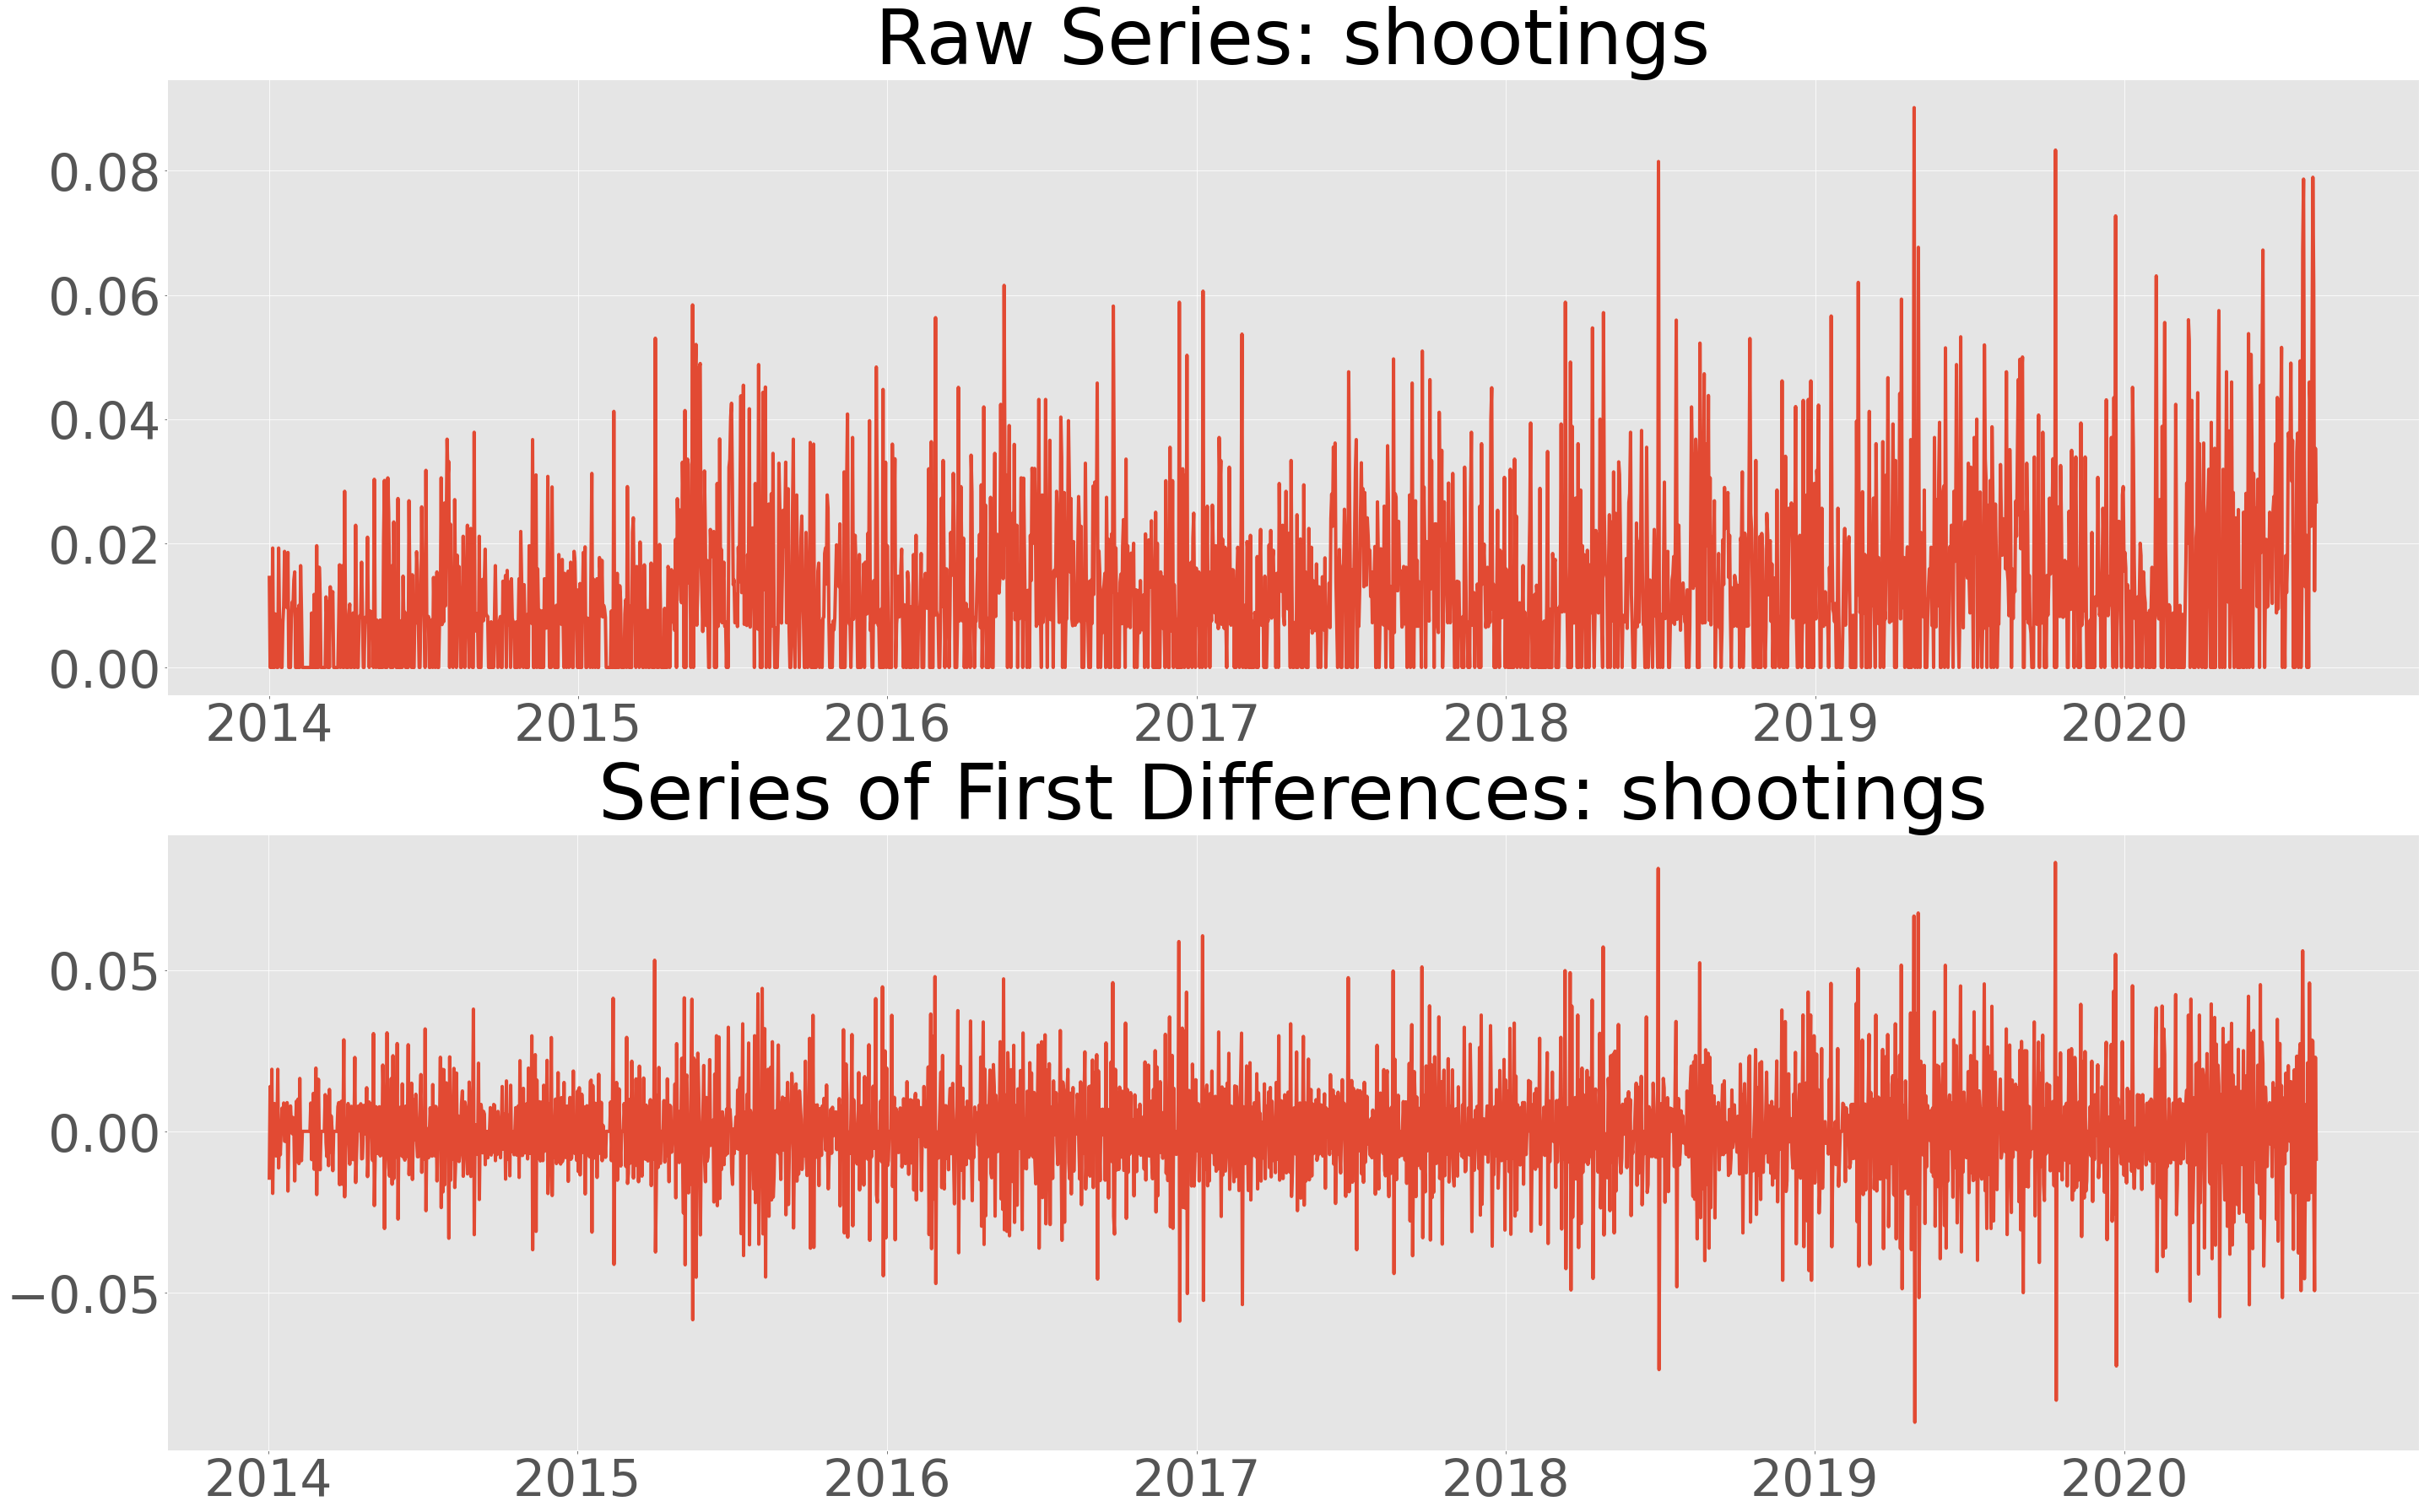

In [66]:
fig, axs = plt.subplots(2, figsize=(40, 25))
plt.rc('axes', titlesize=90)     
# plt.rc('axes', labelsize=60)   
plt.rc('xtick', labelsize=60)
plt.rc('ytick', labelsize=60)    
# plt.rc('legend', fontsize=SMALL)
plt.rc('lines', linewidth=4)
plot_series_and_difference(axs, series, 'shootings')
fig.tight_layout()

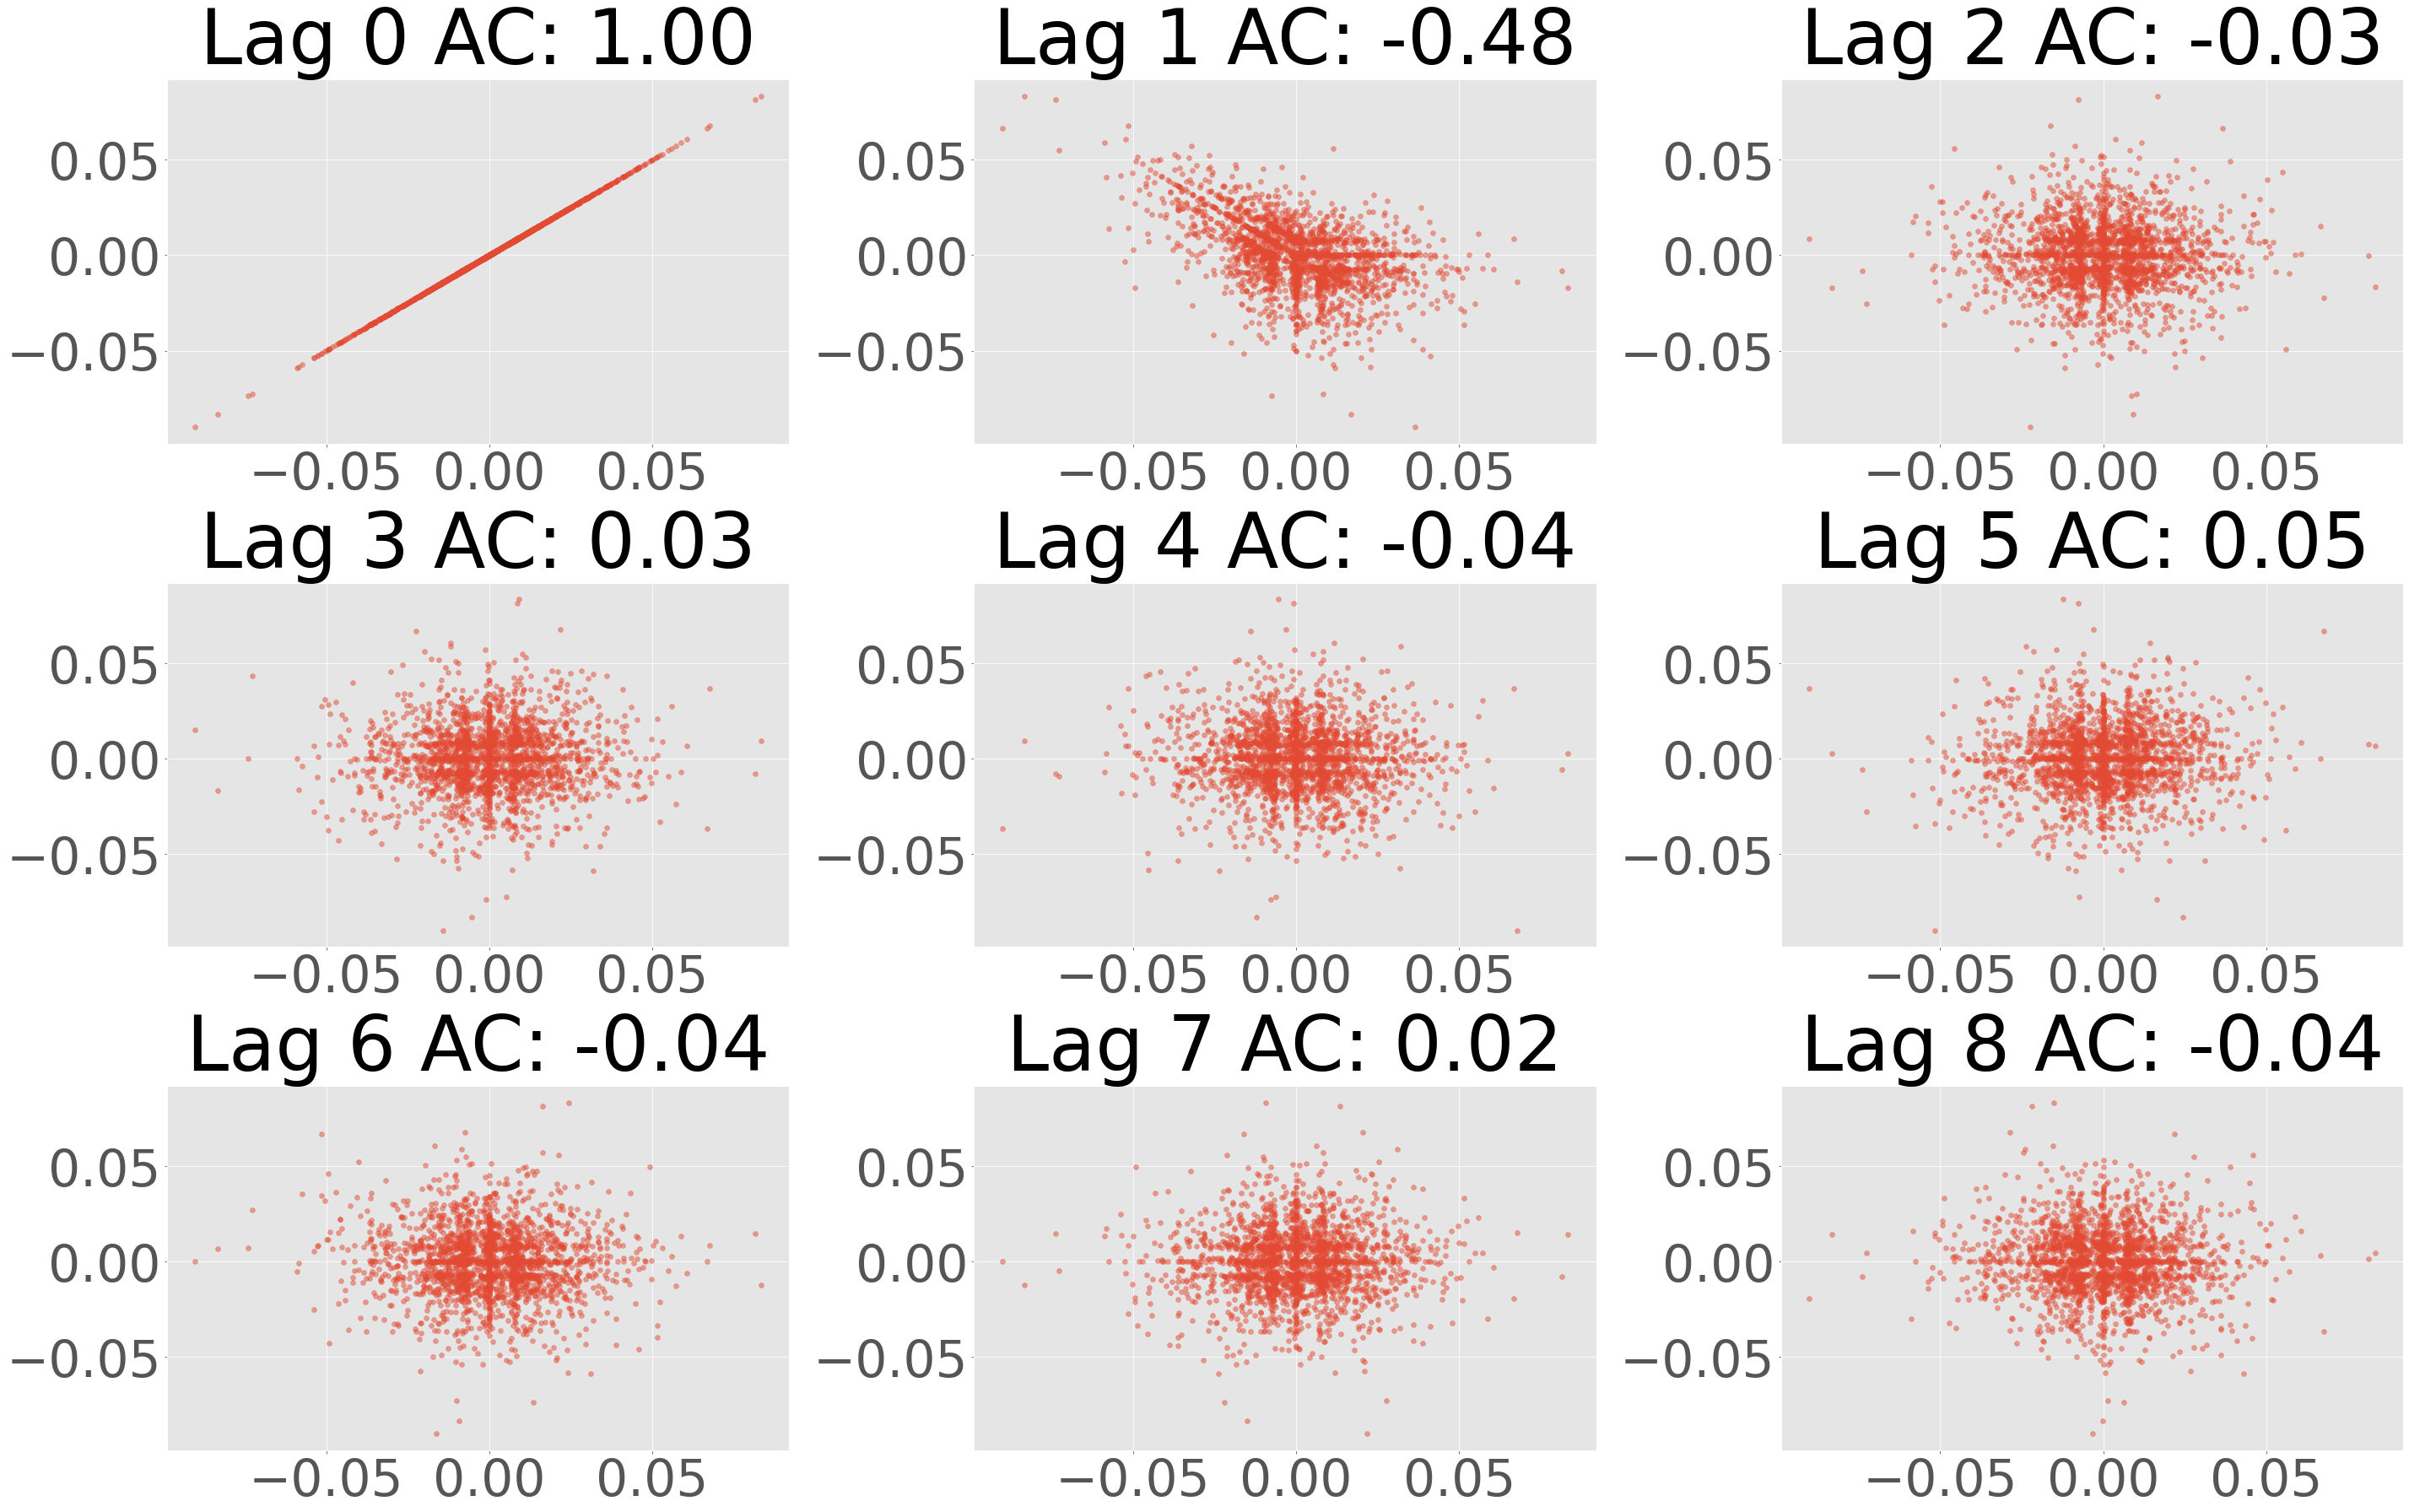

In [69]:
crime_diff = df2.groupby(df2.index).mean()['SHOOTING'].diff()[1:]

fig, axs = plt.subplots(3, 3, figsize=(40, 25))

for i, ax in enumerate(axs.flatten()):
    series, lagged = series_and_lagged(crime_diff, lag=i)
    autocorr = compute_autocorrelation(crime_diff, lag=i)
    ax.scatter(series, lagged, alpha=0.5)
    ax.set_title("Lag {0} AC: {1:2.2f}".format(i, autocorr))
    
plt.tight_layout()

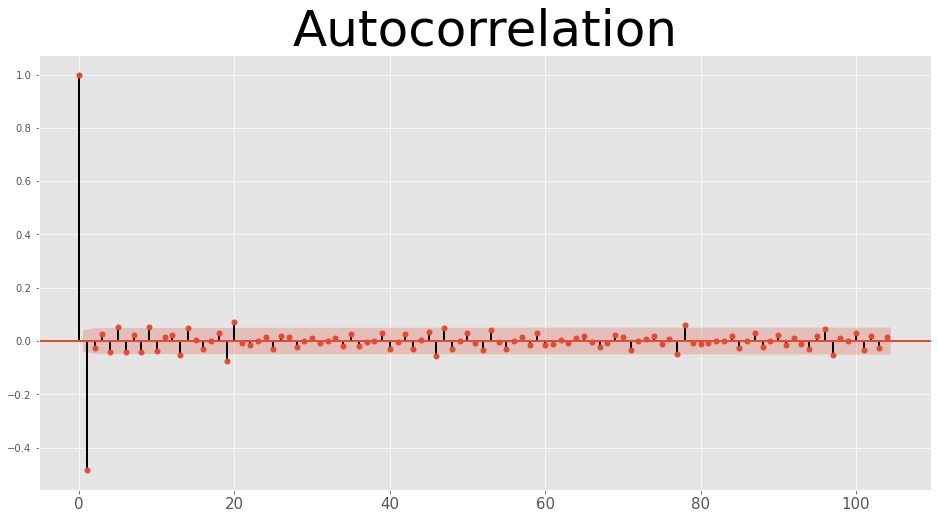

In [121]:
fig, ax = plt.subplots(1, figsize=(16, 8))
plt.rc('lines', linewidth=2)
plt.rc('axes', titlesize=50)     
# plt.rc('axes', labelsize=60)   
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=10)    
# plt.rc('legend', fontsize=SMALL

_ = sm.graphics.tsa.plot_acf(crime_diff, lags=2*52, ax=ax)

For the Shooting example:

There is an interesting striking spike at exactly weeks 20 and 77 lags. 

No significant spikes at 40.

The first, 20th, and 77th autocorrelations are positive and significant.

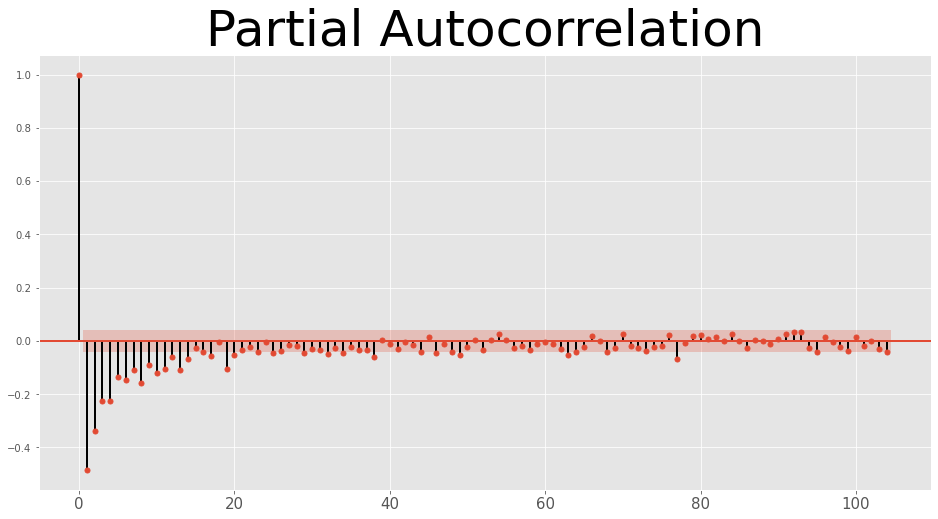

In [122]:
fig, ax = plt.subplots(1, figsize=(16, 8))

plt.rc('lines', linewidth=2)
plt.rc('axes', titlesize=50)     
# plt.rc('axes', labelsize=60)   
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=10) 

_ = sm.graphics.tsa.plot_pacf(crime_diff, lags=2*52, ax=ax)


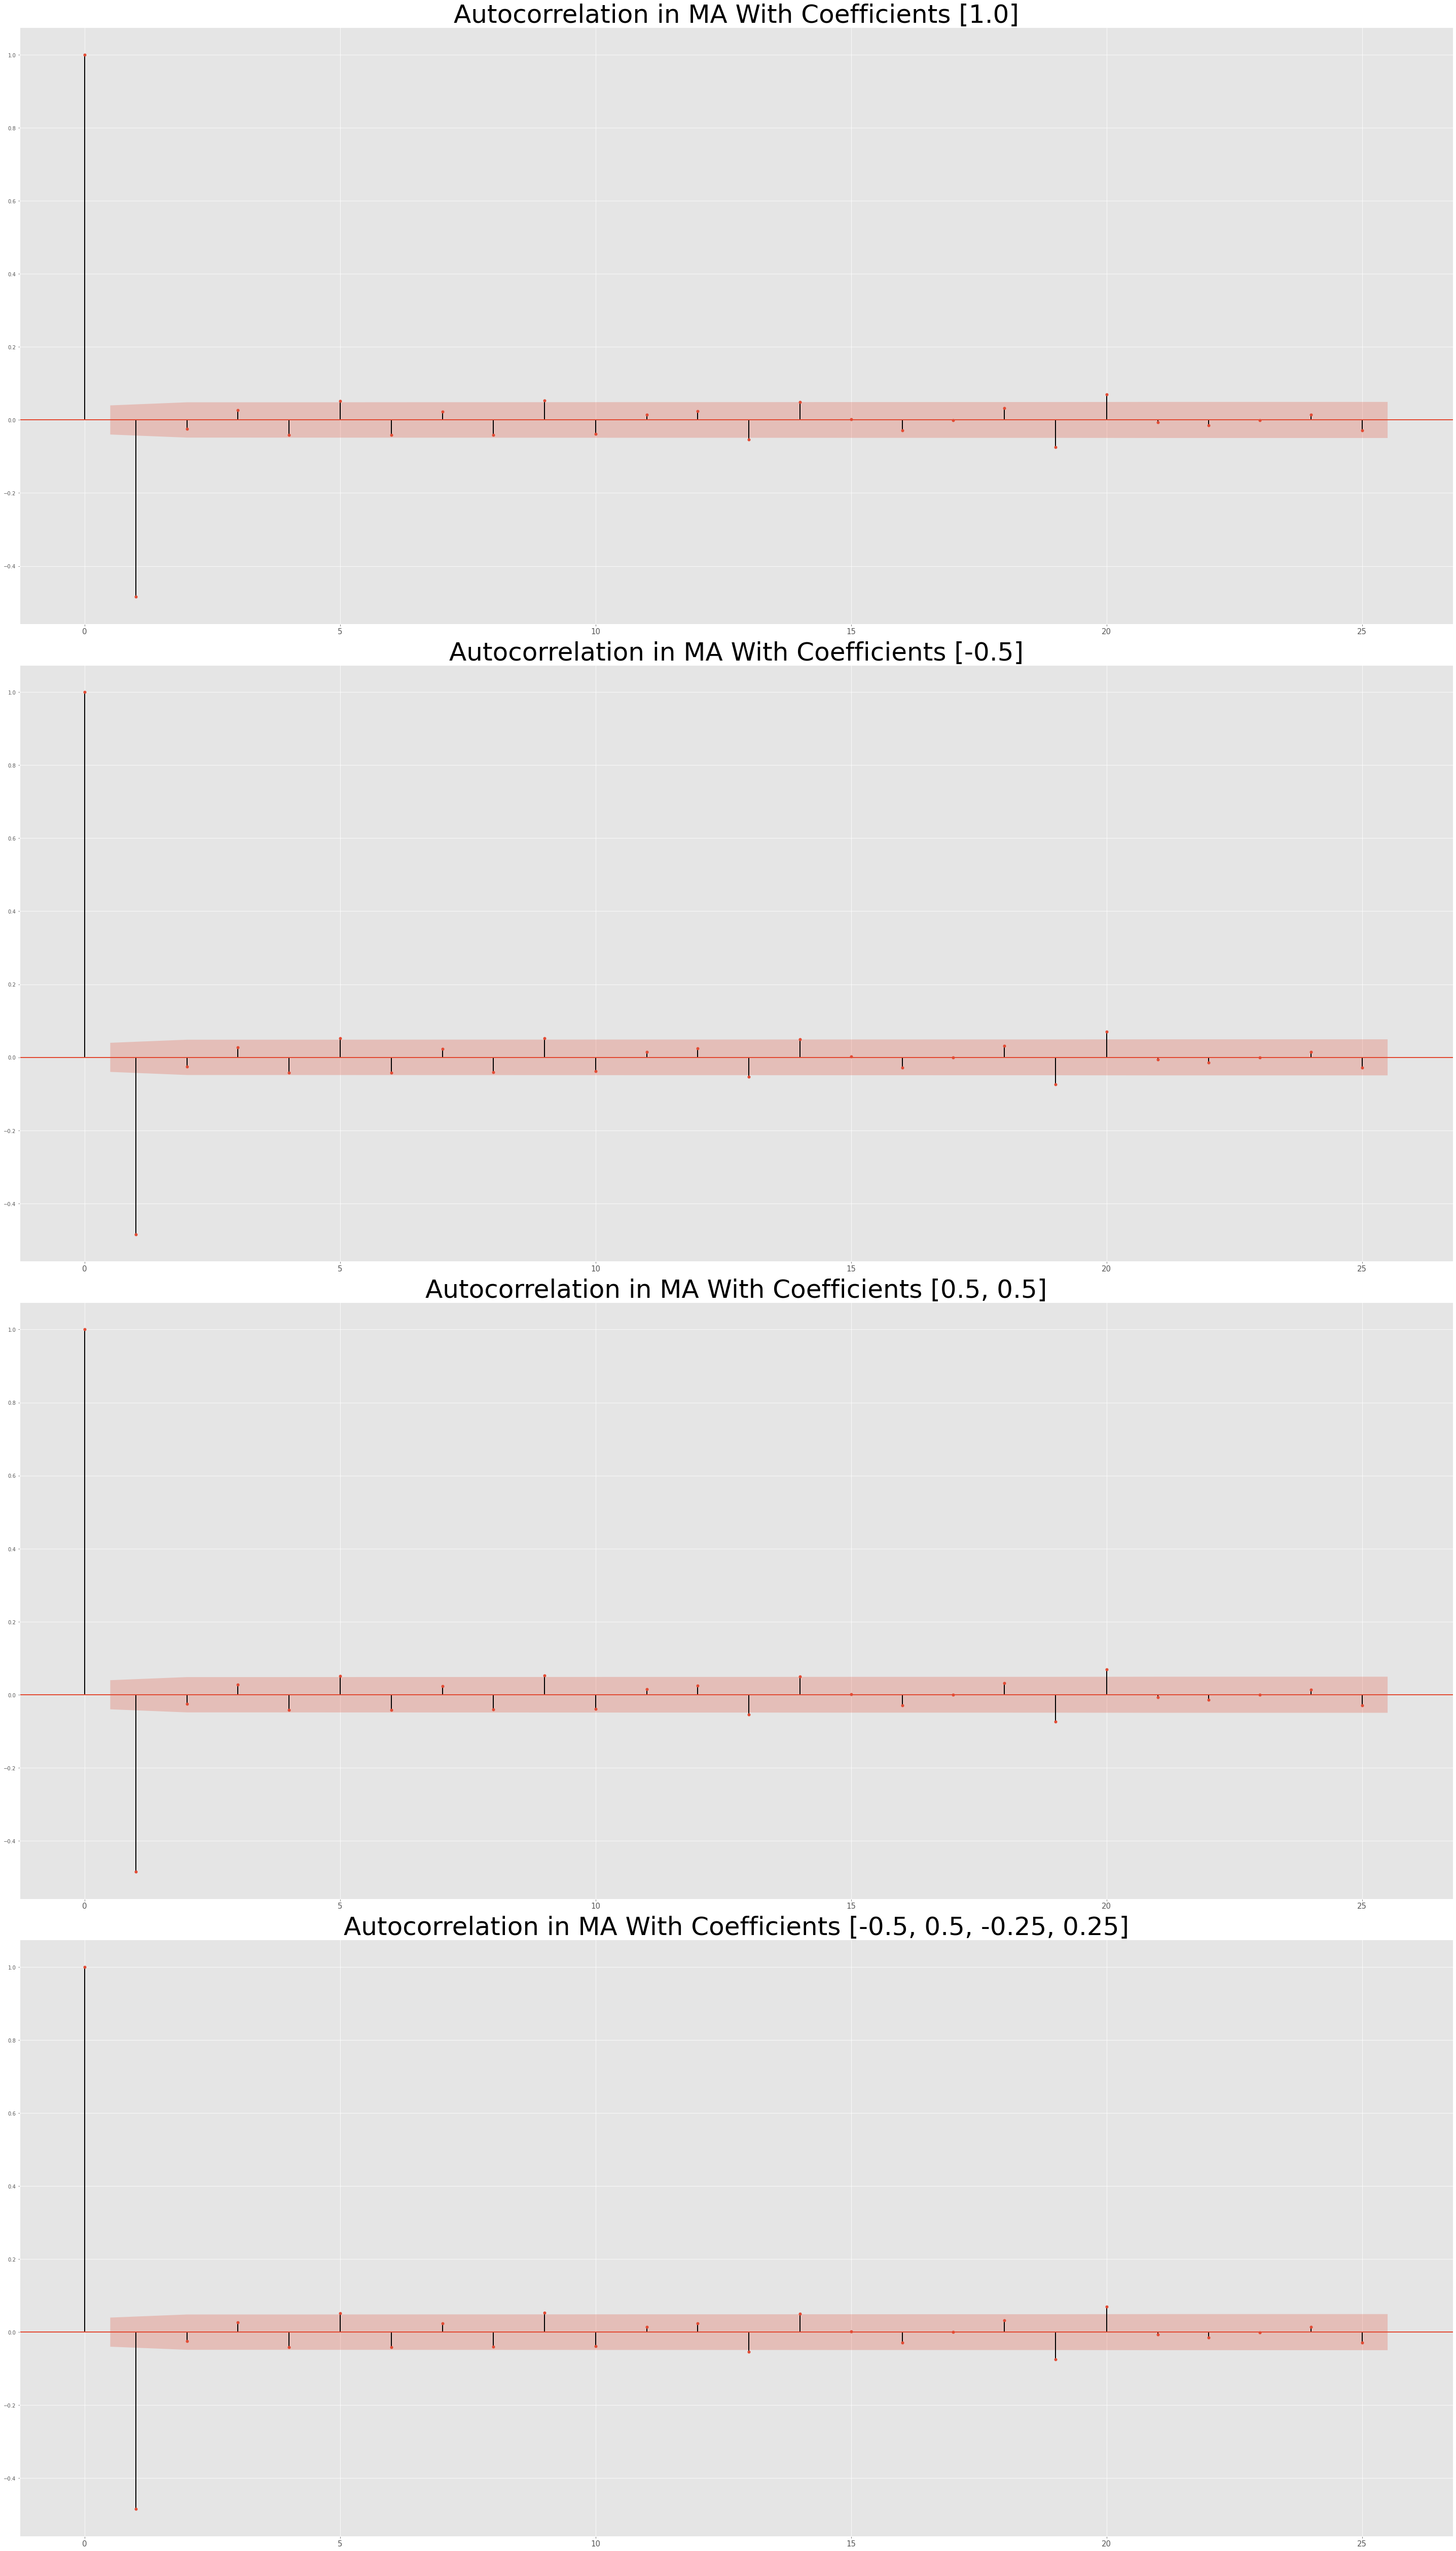

In [168]:
fig, axs = plt.subplots(4, figsize=(40, 70))


plt.rc('lines', linewidth=2)
plt.rc('axes', titlesize=50)     
# plt.rc('axes', labelsize=60)   
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=10) 

ma_coefs = [[1, 1.0], [1, -0.5], [1, 0.5, 0.5], [1, -0.5, 0.5, -0.25, 0.25]]
for i, (ax, coef) in enumerate(zip(axs, ma_coefs)):
    series = linear_combination_of_white_noise(size=100, coef=coef)
    _ = sm.graphics.tsa.plot_acf(crime_diff, lags=25, ax=ax)
    ax.set_title("Autocorrelation in MA With Coefficients {}".format(str(list(coef[1:]))))
    
plt.tight_layout()

In [172]:
def fit_ma_model(crime_series, order):
    # ARIMA is a more general model, which we are going to build up
    # in pieces.
    model = ARIMA(crime_series, order=(0, 0, order))
    return model.fit()

In [173]:
def format_list_of_floats(L):
    return ["{0:2.2f}".format(f) for f in L]

In [175]:
for coef in ma_coefs:
    ma_series = linear_combination_of_white_noise(size=250, coef=coef)
    ma_model = fit_ma_model(ma_series.values, order=(len(coef) - 1))
    print("True Coefficients: {0: <20} Estimated Coefficients: {1: <20}".format(
            str(format_list_of_floats(coef[1:])),
            str(format_list_of_floats(ma_model.params[1:]))))

True Coefficients: ['1.00']             Estimated Coefficients: ['0.95']            
True Coefficients: ['-0.50']            Estimated Coefficients: ['-0.60']           
True Coefficients: ['0.50', '0.50']     Estimated Coefficients: ['0.47', '0.58']    
True Coefficients: ['-0.50', '0.50', '-0.25', '0.25'] Estimated Coefficients: ['-0.48', '0.47', '-0.39', '0.35']


In [176]:
def arima_process(size, ar_coefs, ma_coefs, d=0):
    """Simulate a series from an arima model."""
    arma = ArmaProcess(ar_coefs, ma_coefs)
    arma_series = arma.generate_sample(size + d)
    # Integrate d times.
    for i in range(d):
        arma_series = np.cumsum(arma_series)
    return pd.Series(arma_series)

In [177]:
def plot_arima_process(ax, size, ar_coefs, ma_coefs, d=0):
    series = arima_process(size, ar_coefs, ma_coefs, d)
    ax.plot(series.index, series)

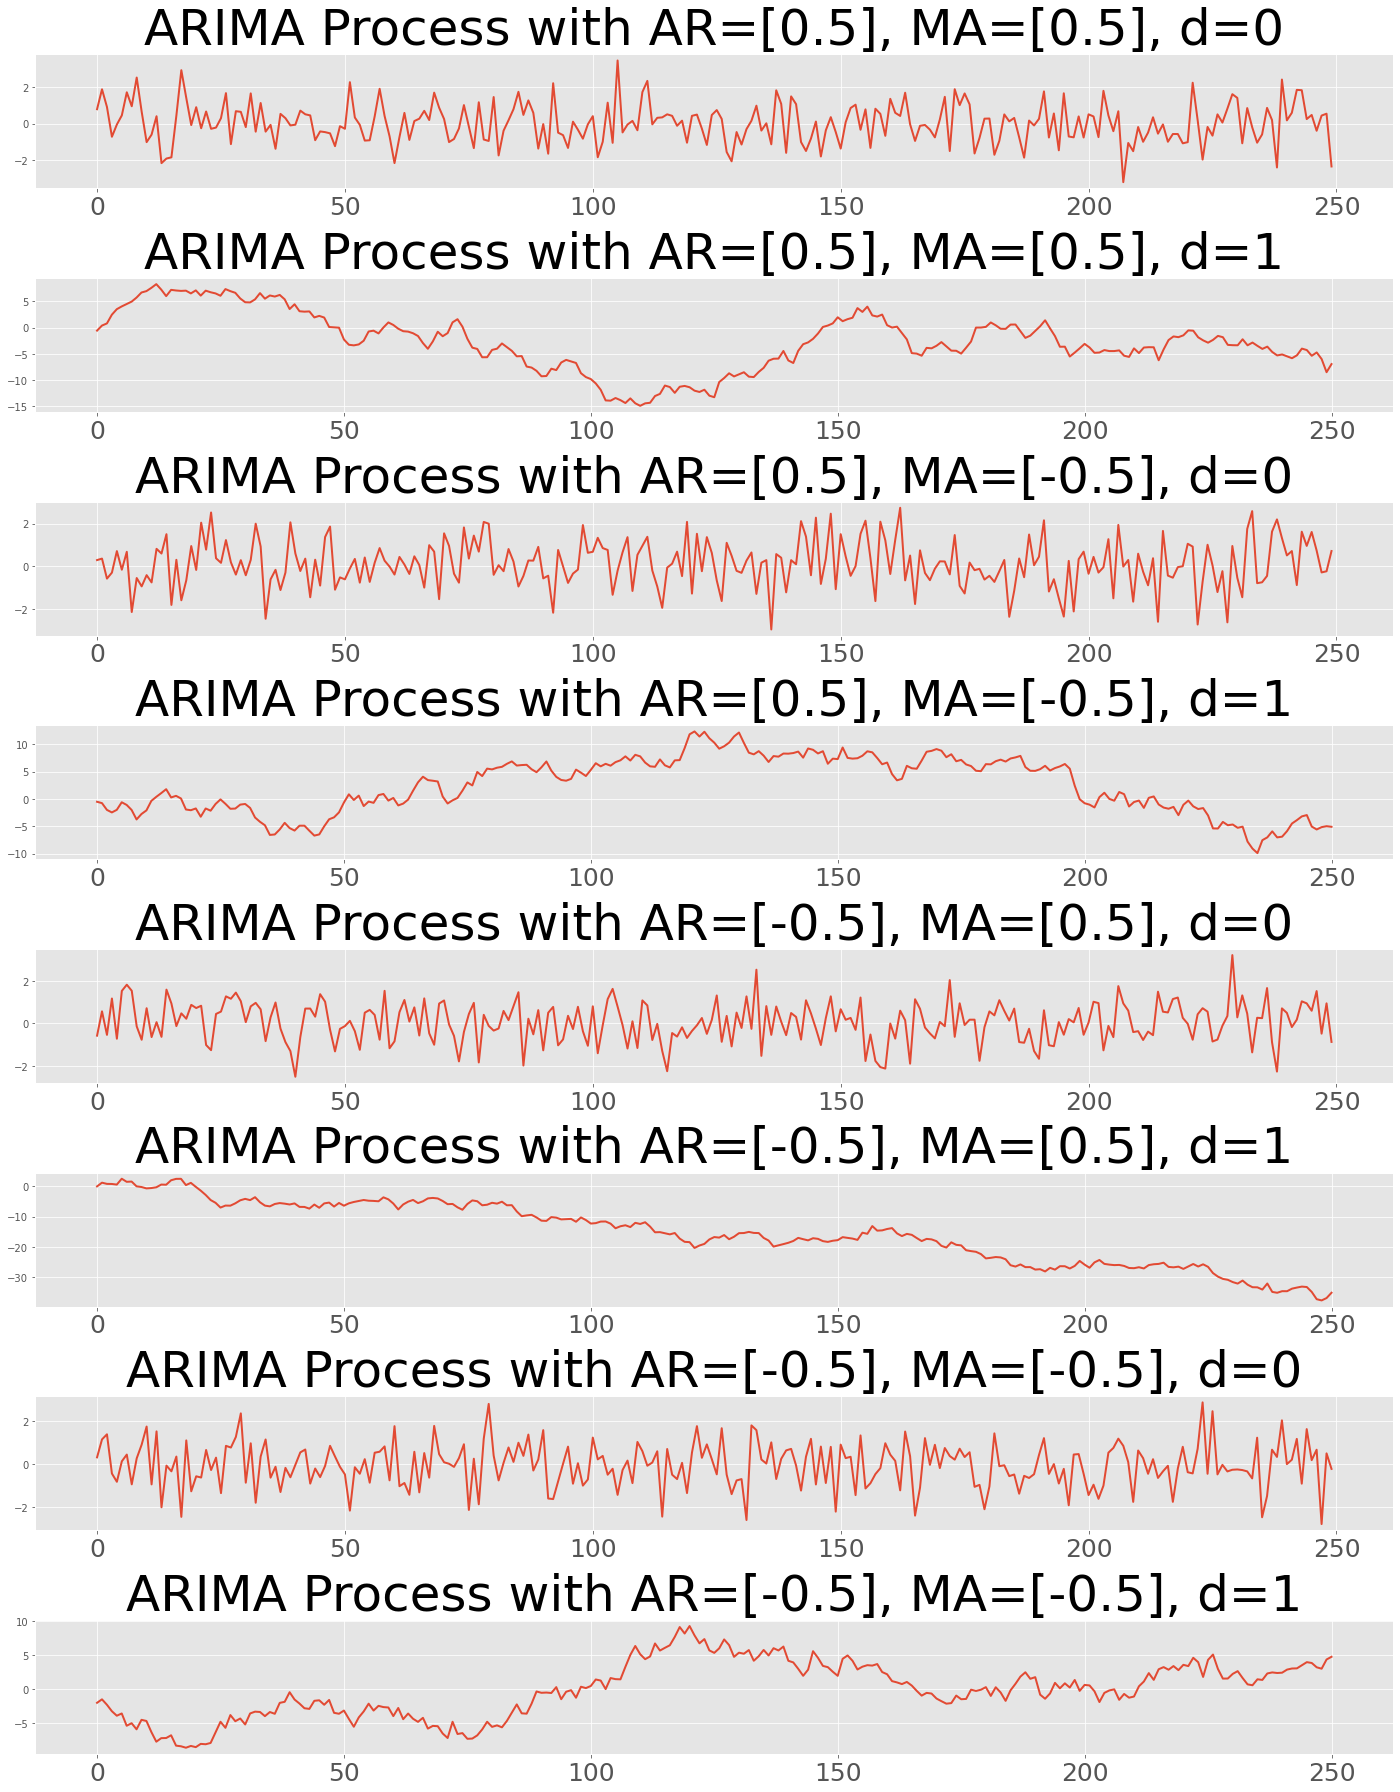

In [181]:
ar_coefs = [[0.5], [-0.5]]
ma_coefs = [[0.5], [-0.5]]
ds = [0, 1]

fig, axs = plt.subplots(8, figsize=(20, 25))

for ax, (ar, ma, d) in zip(axs, itertools.product(ar_coefs, ma_coefs, ds)):
    plot_arima_process(ax, 250, ar, ma, d)
    ax.set_title("ARIMA Process with AR={}, MA={}, d={}".format(
        str(list(ar)), str(list(ma)), d))
    
plt.tight_layout()

In [182]:
crime_series.head()

WEEK
1    0.008140
1    0.006849
1    0.016630
1    0.011905
1    0.012472
Name: SHOOTING, dtype: float64